reference: [https://arxiv.org/pdf/1505.04597]

In [2]:
import os
import cv2
import math
from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torchvision import transforms as T


root_path = "/kaggle/input/camvid/CamVid"
class_dict_path = os.path.join(root_path, "class_dict.csv")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
H = 704
W = 960
scale = 2
batch_size = 8

# Data pre processing / exploration

In [3]:
class CVDataset(Dataset):
    def __init__(self, path=root_path, split="train", class_dict_path=class_dict_path):
        self.root_path = path
        self.images_dir = os.path.join(self.root_path, split)
        self.masks_dir = os.path.join(self.root_path, f"{split}_labels")
        self._images = [f for f in sorted(os.listdir(self.images_dir))]
        self._masks = [f for f in sorted(os.listdir(self.masks_dir))]            
        self.n = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.t = T.ToTensor()
        self.label_encoder = {
            (row['r'], row['g'], row['b']): idx
            for idx, row in pd.read_csv(class_dict_path).iterrows()
        }


    def __len__(self):
        return len(self._images)

    
    def _label_encoder(self, mask):
        h, w, _ = mask.shape
        encoded = np.zeros((h, w), dtype=np.int32)
        for r, g, b in self.label_encoder.keys():
            match = (mask[:, :, 0] == r) & (mask[:, :, 1] == g) & (mask[:, :, 2] == b)
            encoded[match] = self.label_encoder[(r, g, b)]
        return encoded
    
    def __getitem__(self, idx):
        image_name = self._images[idx]
        mask_name = self._masks[idx]

        image_path = os.path.join(self.images_dir, image_name)
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)
        mask = self._label_encoder(mask)
        image = cv2.resize(image, (H//scale, W//scale), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (H//scale, W//scale), interpolation=cv2.INTER_NEAREST)

        if torch.randn(1).item() > 0:
            image = cv2.flip(image, 1)
            mask = cv2.flip(mask, 1)
        
        image, mask = self.t(image), self.t(mask)
        image = self.n(image)
        mask = mask.squeeze(0)

        return image, mask.long()

In [4]:
H, H/16, W, W/16, 44*16, 60*16

(704, 44.0, 960, 60.0, 704, 960)

In [5]:
train_dataset = CVDataset(root_path, split="train")
test_dataset = CVDataset(root_path, split="test")
val_dataset = CVDataset(root_path, split="val")

num_workers=4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [6]:
for image, mask in val_loader:
    print(image.size(), mask.size())
    print(image.dtype, mask.dtype)
    break

torch.Size([8, 3, 480, 352]) torch.Size([8, 480, 352])
torch.float32 torch.int64


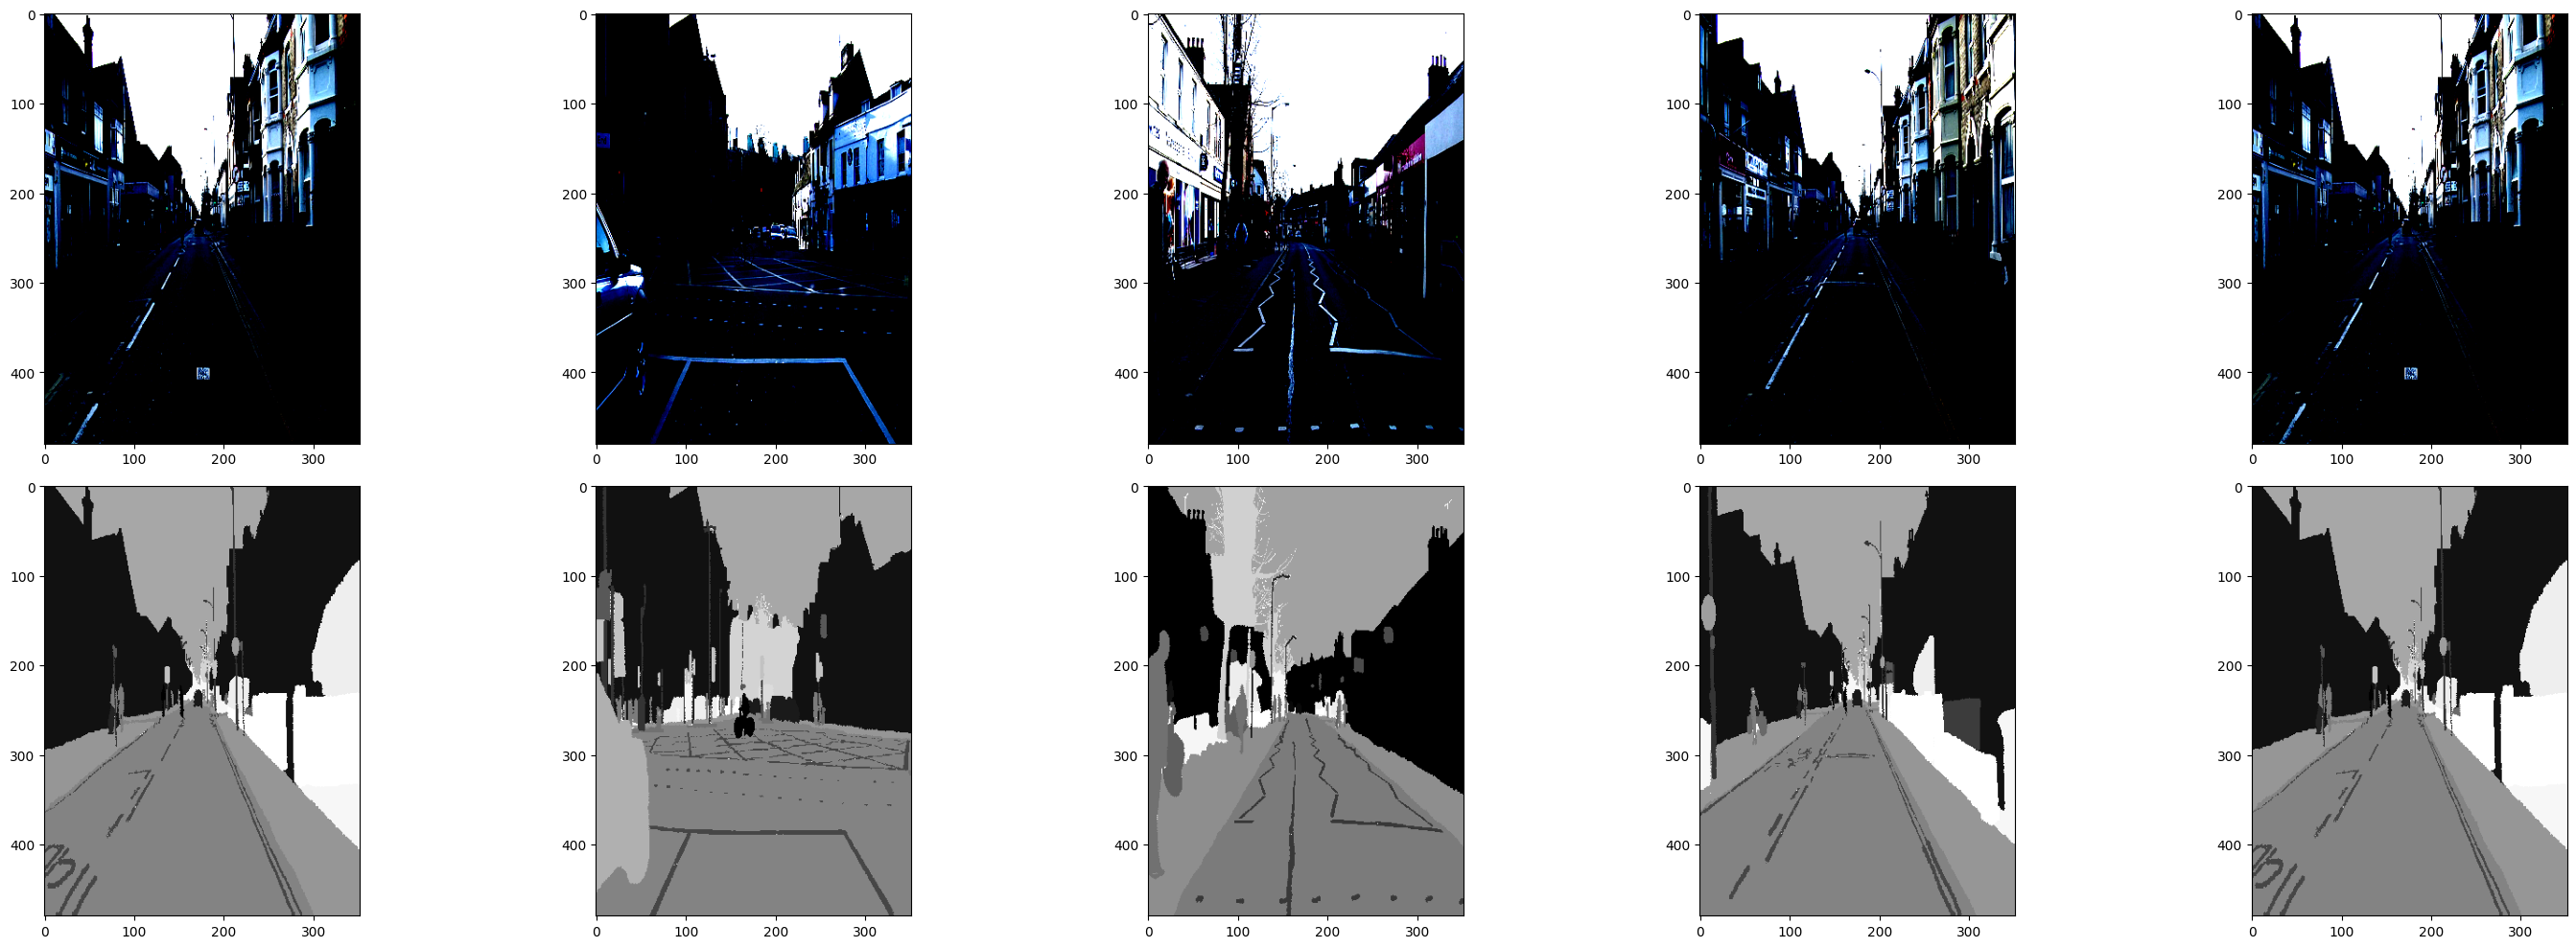

In [7]:
image = image[:4]
mask = mask[:4]
num_rows = 2
num_cols = len(image) + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 10))

for i in range(num_cols):
    axes[0, i].imshow(image[i%len(image)].permute(1, 2, 0))
    axes[1, i].imshow(mask[i%len(image)], cmap="gray")

plt.tight_layout()
plt.show()

In [8]:
image.min(), image.max(), image.float().mean(), image.float().std()

(tensor(-2.1179), tensor(2.6400), tensor(-0.0735), tensor(1.3368))

# Model Definition: U-Net 

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.activation = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.activation(x)
        x = self.bn2(self.conv2(x))
        return self.activation(x)
        

In [10]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # print(in_channels, out_channels)
        self.conv = ConvBlock(in_channels, out_channels)
        self.down = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        # print(x.size())
        skip_connection = self.conv(x)
        down = self.down(skip_connection)
        return down, skip_connection

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # print(in_channels, out_channels)
        self.conv = ConvBlock(in_channels, out_channels)
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # up/dow i: conv block at level i
        
        # concatenation_path
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)

        self.bottle_neck = ConvBlock(512, 1024)
        
        # expansion_path
        self.up4 = UpSample(1024, 512)
        self.up3 = UpSample(512, 256)
        self.up2 = UpSample(256, 128)
        self.up1 = UpSample(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

        
        
    def forward(self, x):
        x, skip1 = self.down1(x)        
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)        
        x, skip4 = self.down4(x)

        x = self.bottle_neck(x)

        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)

        return self.out(x)

In [12]:
def compute_class_weights(loader, num_classes, device):
    classes_counter = torch.zeros(num_classes)
    smoother = 1e-6
    for _, mask in tqdm(loader):
        mask = mask.view(-1)
        classes_counter += torch.bincount(mask, minlength=num_classes)
    
    total = classes_counter.sum().item()
    class_weights = total / (classes_counter + smoother)
    
    class_weights /= class_weights.sum()
    return class_weights.to(device)

In [13]:
num_classes = len(train_dataset.label_encoder)

In [14]:
class_weights = compute_class_weights(train_loader, num_classes, device)

100%|██████████| 47/47 [00:26<00:00,  1.80it/s]


In [15]:
class_weights, num_classes

(tensor([3.3591e-10, 3.3918e-11, 3.3878e-12, 3.7591e-11, 7.0222e-14, 5.1436e-13,
         6.1805e-11, 5.1138e-11, 1.5511e-12, 9.6060e-13, 8.5966e-13, 1.4333e-10,
         2.4451e-12, 2.8736e-10, 3.4156e-12, 4.5616e-12, 2.5904e-12, 5.6348e-14,
         6.5784e-12, 2.3465e-13, 1.2336e-11, 1.0576e-13, 3.0242e-12, 4.1494e-10,
         4.4174e-12, 1.0000e+00, 1.5831e-13, 8.6179e-12, 1.0000e-06, 1.9530e-12,
         6.1136e-13, 1.3014e-12], device='cuda:0'),
 32)

In [16]:
class_weights[-4] *= 1e-3
class_weights[-7] *= 1e-9
a = (class_weights - class_weights.mean()) / class_weights.std()
a = (a - a.min()) / (a.max() - a.min())
a = a + a.mean()
a /= a.sum()
a

tensor([0.0647, 0.0206, 0.0161, 0.0211, 0.0156, 0.0157, 0.0246, 0.0231, 0.0158,
        0.0158, 0.0157, 0.0365, 0.0160, 0.0576, 0.0161, 0.0163, 0.0160, 0.0156,
        0.0166, 0.0157, 0.0174, 0.0156, 0.0161, 0.0762, 0.0163, 0.1616, 0.0156,
        0.0169, 0.1616, 0.0159, 0.0157, 0.0158], device='cuda:0')

In [17]:
class_weights = a

In [18]:
class_weights

tensor([0.0647, 0.0206, 0.0161, 0.0211, 0.0156, 0.0157, 0.0246, 0.0231, 0.0158,
        0.0158, 0.0157, 0.0365, 0.0160, 0.0576, 0.0161, 0.0163, 0.0160, 0.0156,
        0.0166, 0.0157, 0.0174, 0.0156, 0.0161, 0.0762, 0.0163, 0.1616, 0.0156,
        0.0169, 0.1616, 0.0159, 0.0157, 0.0158], device='cuda:0')

In [32]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='sum'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # Get probabilities
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [18]:
epochs = 80
learning_rate = 1e-3
num_classes = len(train_dataset.label_encoder)

model = UNet(3, num_classes).to(device)

# using a slightly high first momentum coef to compensate for the low batch size
optimizer = optim.AdamW(model.parameters(), learning_rate, weight_decay=.01, betas=(.95, .999))

lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    div_factor=20,
    final_div_factor=200
)
criterion = FocalLoss(alpha=1.0, gamma=2.0)
# tracker = MetricsTracker(num_classes, device)

# Model training

In [19]:
smoother = 1e-6

@torch.no_grad()
def dice(pred, target):
    pred = pred.argmax(1)
    
    dice = 0
    for cls in range(num_classes):
        pred_mask = (pred == cls)
        target_mask = (target == cls)
        intersection = (pred_mask & target_mask).sum(dim=(1, 2))
        union = pred_mask.sum(dim=(1, 2)) + target_mask.sum(dim=(1, 2))
        dice += (2 * intersection / (union + smoother)).mean() * class_weights[cls]

    dice = dice / num_classes
    return dice

@torch.no_grad()
def iou(pred, target):
    iou = 0
    pred = pred.argmax(1)
    
    for cls in range(num_classes):
        pred_mask = (pred == cls)
        target_mask = (target == cls)
        
        intersection = (pred_mask & target_mask).sum(dim=(1, 2))
        union = (pred_mask | target_mask).sum(dim=(1, 2))
        
        iou_per_sample = intersection / (union + 1e-6)
        
        iou += iou_per_sample.mean() * class_weights[cls]
    iou = iou / num_classes
    return iou

@torch.no_grad()
def accuracy(pred, target):
    pred = pred.argmax(1)
    correct = (pred == target)
    accuracy = 0

    for cls in range(num_classes):
        class_mask = (target == cls)
        total_class_pixels = class_mask.sum(dim=(1, 2))

        valid_samples = total_class_pixels > 0
        if valid_samples.any():
            correct_class = (correct * class_mask).sum(dim=(1, 2))
            acc_per_sample = correct_class[valid_samples] / total_class_pixels[valid_samples]
            accuracy += acc_per_sample.mean() * class_weights[cls]

    accuracy = accuracy / num_classes
    return accuracy

* note: performance metrics aren't that representative due to high classes variance & imbalance

100%|██████████| 47/47 [00:32<00:00,  1.44it/s]


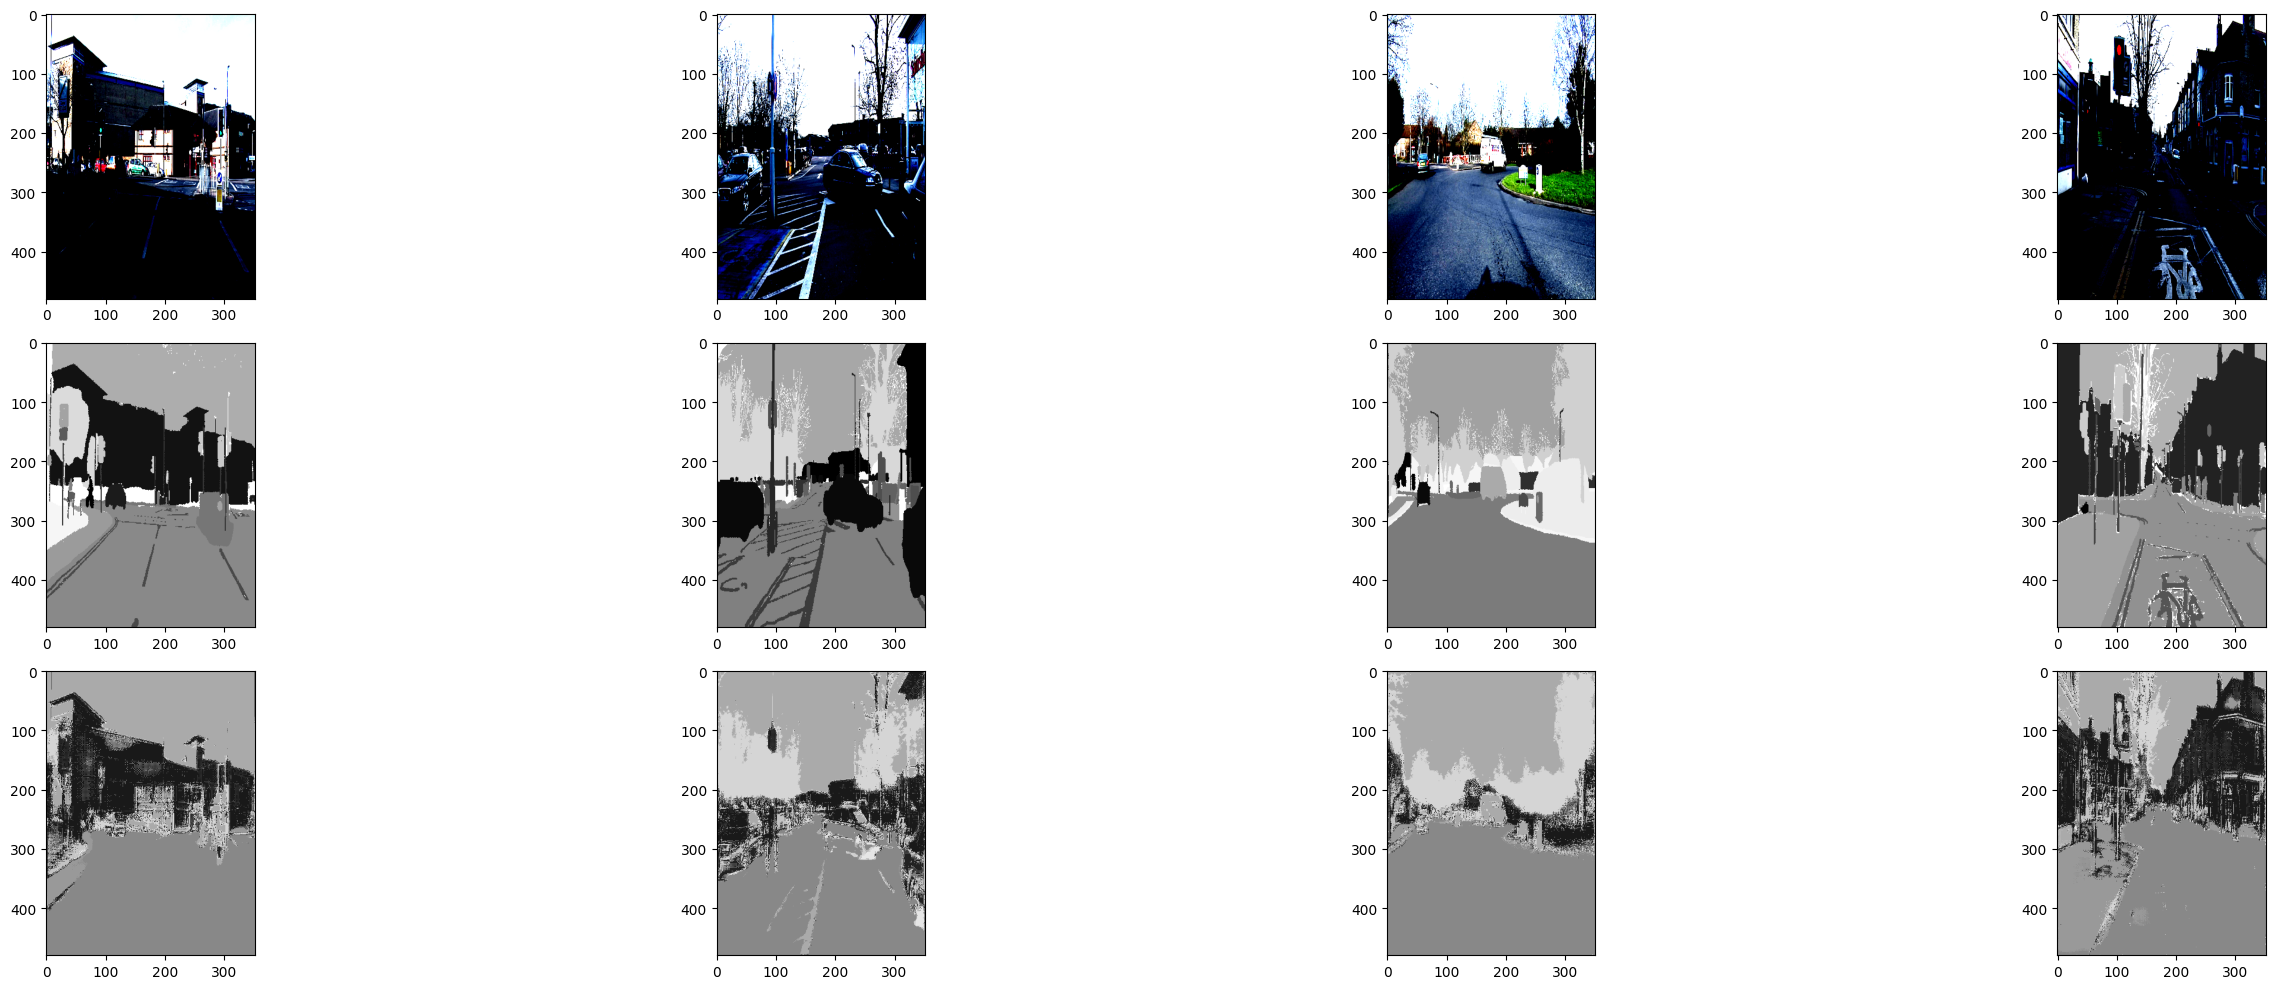

epoch 1/80 loss: 3212747.878324468, acc: 0.0012987536611035466, dic: 0.0011057574301958084, iou: 0.0008756291936151683
epoch 1/80 val_loss: 2302776.278846154, val_acc: 0.0018196182791143656, val_dic: 0.0015811861958354712, val_iou: 0.0012859540292993188


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 2/80 loss: 2166673.436170213, acc: 0.002017124556005001, dic: 0.0017311056144535542, iou: 0.0014483960112556815
epoch 2/80 val_loss: 1841128.9086538462, val_acc: 0.0018537433352321386, val_dic: 0.001602935721166432, val_iou: 0.0013424530625343323


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 3/80 loss: 1702627.819481383, acc: 0.002151769120246172, dic: 0.0018462487496435642, iou: 0.001574781141243875
epoch 3/80 val_loss: 1549006.4615384615, val_acc: 0.002077443292364478, val_dic: 0.0017974689835682511, val_iou: 0.0015332107432186604


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 4/80 loss: 1435099.2373670214, acc: 0.002208956051617861, dic: 0.0018961570458486676, iou: 0.0016180167440325022
epoch 4/80 val_loss: 1564572.7596153845, val_acc: 0.002126239938661456, val_dic: 0.0017714551649987698, val_iou: 0.0014912172919139266


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 5/80 loss: 1217011.043218085, acc: 0.0023221010342240334, dic: 0.0019891068805009127, iou: 0.0017030949238687754
epoch 5/80 val_loss: 1088870.0576923077, val_acc: 0.002464121440425515, val_dic: 0.0020658615976572037, val_iou: 0.001771961455233395


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 6/80 loss: 987730.9360039893, acc: 0.0026226742193102837, dic: 0.002279383596032858, iou: 0.0019330340437591076
epoch 6/80 val_loss: 1064829.701923077, val_acc: 0.0022920696064829826, val_dic: 0.002090809401124716, val_iou: 0.0017432209569960833


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 7/80 loss: 832080.0688164893, acc: 0.0029038903303444386, dic: 0.002490978455170989, iou: 0.002115162555128336
epoch 7/80 val_loss: 925581.4375, val_acc: 0.0028213998302817345, val_dic: 0.00236687739379704, val_iou: 0.001999506726861


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 8/80 loss: 745056.2839095745, acc: 0.0030044803861528635, dic: 0.002559883054345846, iou: 0.002172220731154084
epoch 8/80 val_loss: 790772.5216346154, val_acc: 0.00300373206846416, val_dic: 0.002498286310583353, val_iou: 0.0020984578877687454


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 9/80 loss: 723020.9451462766, acc: 0.0030294687021523714, dic: 0.002573298057541251, iou: 0.002171957865357399
epoch 9/80 val_loss: 868178.9326923077, val_acc: 0.002911966759711504, val_dic: 0.00236688693985343, val_iou: 0.0019493126310408115


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 10/80 loss: 657614.3746675532, acc: 0.0031214114278554916, dic: 0.0026652796659618616, iou: 0.0022579773794859648
epoch 10/80 val_loss: 1559795.4711538462, val_acc: 0.0023402057122439146, val_dic: 0.0018662766087800264, val_iou: 0.0014441967941820621


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


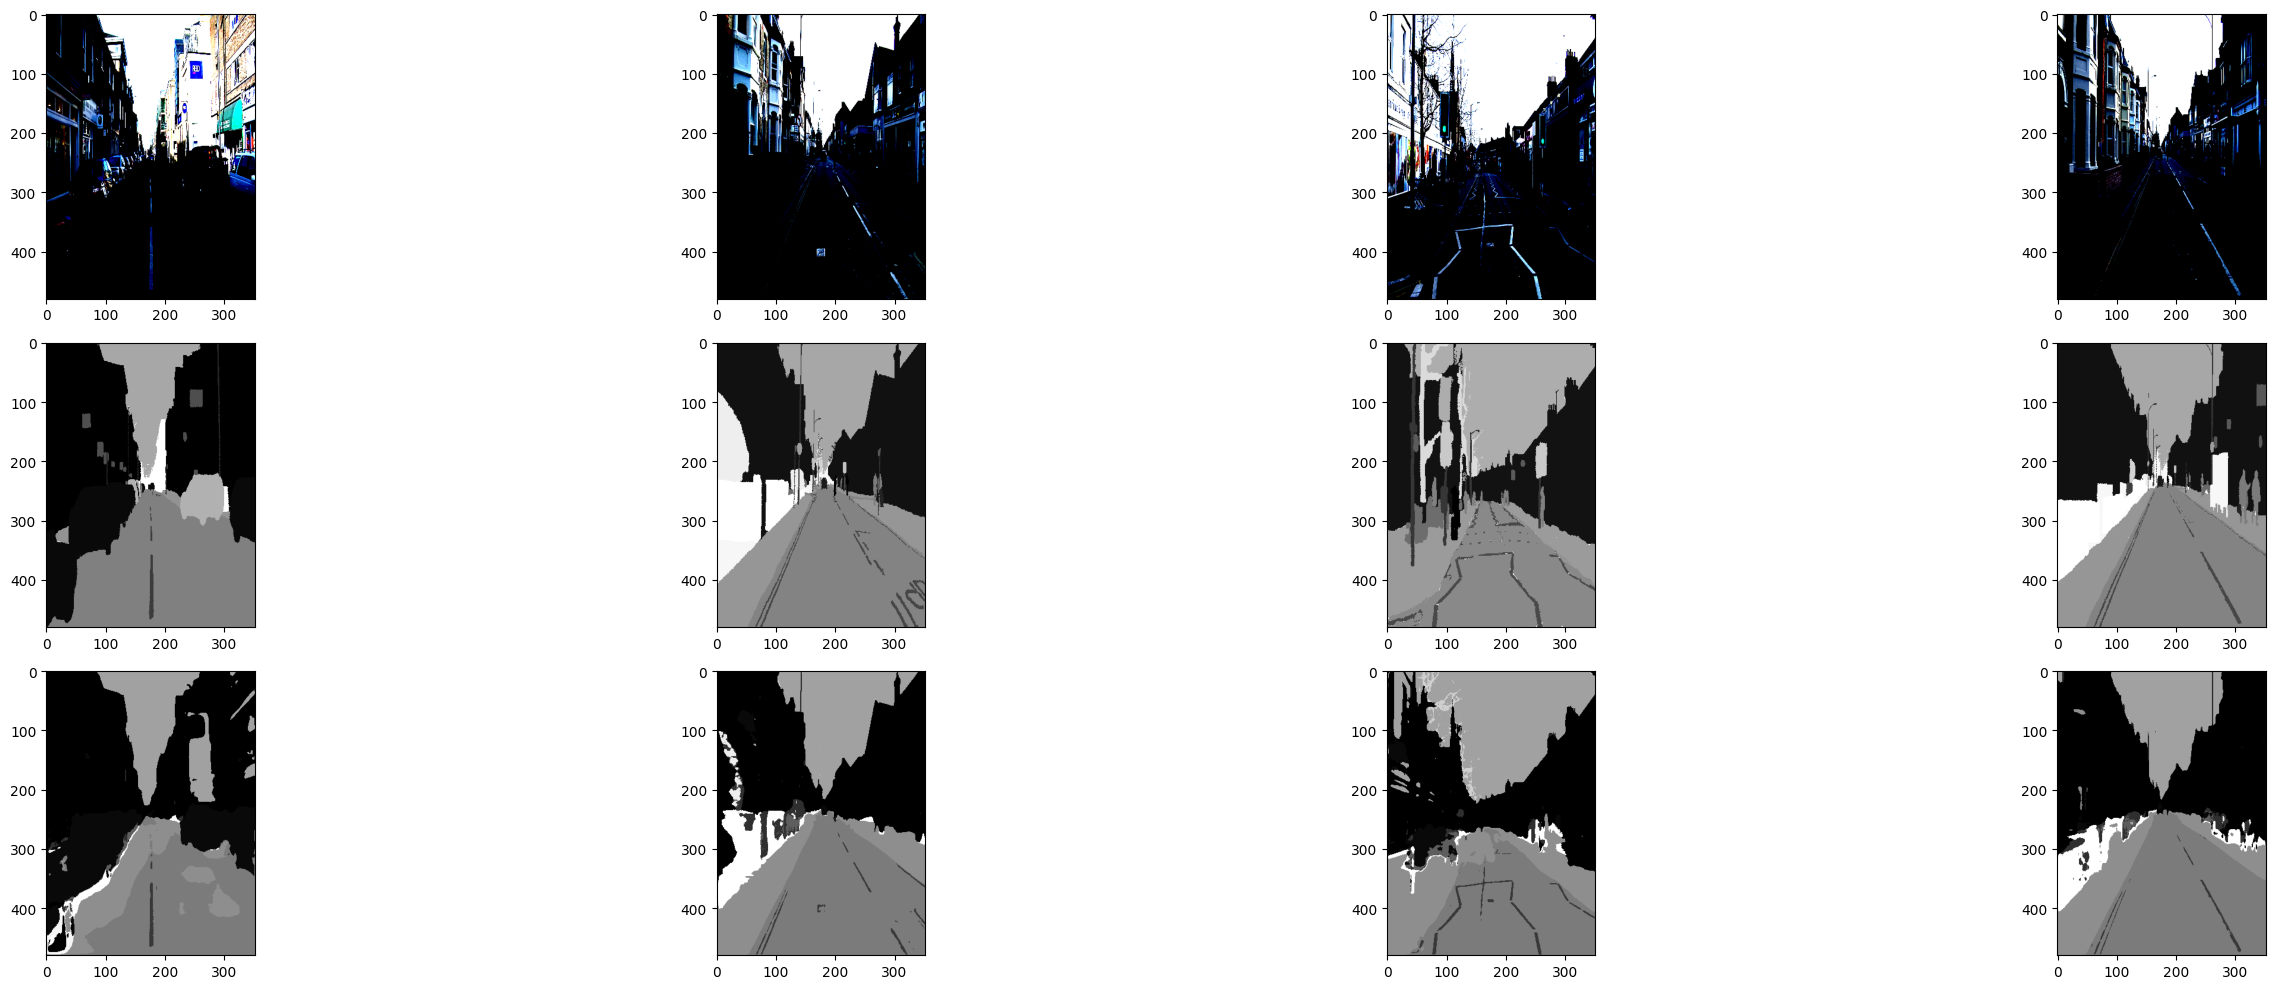

epoch 11/80 loss: 640308.8717586437, acc: 0.003209601156413555, dic: 0.002719441195949912, iou: 0.002295226790010929
epoch 11/80 val_loss: 815350.9230769231, val_acc: 0.0031317947432398796, val_dic: 0.002469082362949848, val_iou: 0.0019926317036151886


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 12/80 loss: 558326.8848071808, acc: 0.003369238693267107, dic: 0.002873398130759597, iou: 0.002426289487630129
epoch 12/80 val_loss: 538620.8305288461, val_acc: 0.003479926846921444, val_dic: 0.002913800301030278, val_iou: 0.0024637500755488873


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 13/80 loss: 546345.8636968085, acc: 0.003369990736246109, dic: 0.0029042945243418217, iou: 0.0024438071995973587
epoch 13/80 val_loss: 1104524.1322115385, val_acc: 0.0031482907943427563, val_dic: 0.0023877942003309727, val_iou: 0.0019289413467049599


100%|██████████| 47/47 [00:30<00:00,  1.52it/s]


epoch 14/80 loss: 547537.6995511968, acc: 0.0034944189246743917, dic: 0.0029655215330421925, iou: 0.0024827048182487488
epoch 14/80 val_loss: 983153.2932692308, val_acc: 0.0029780929908156395, val_dic: 0.0023619437124580145, val_iou: 0.0018790076719596982


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 15/80 loss: 491544.86901595746, acc: 0.003675528336316347, dic: 0.003140378510579467, iou: 0.002626852598041296
epoch 15/80 val_loss: 678001.5144230769, val_acc: 0.0035534703638404608, val_dic: 0.00285354838706553, val_iou: 0.002326332265511155


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 16/80 loss: 478243.24243683513, acc: 0.003824824932962656, dic: 0.003254082752391696, iou: 0.0027183848433196545
epoch 16/80 val_loss: 667236.1586538461, val_acc: 0.003619137220084667, val_dic: 0.0030105309560894966, val_iou: 0.0024628930259495974


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 17/80 loss: 438518.6060505319, acc: 0.003980252891778946, dic: 0.003364657750353217, iou: 0.0028118714690208435
epoch 17/80 val_loss: 581658.5817307692, val_acc: 0.0037616400513798, val_dic: 0.003112201578915119, val_iou: 0.002556259511038661


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 18/80 loss: 424782.1240026596, acc: 0.004055679310113192, dic: 0.003442218294367194, iou: 0.0028797751292586327
epoch 18/80 val_loss: 539793.9014423077, val_acc: 0.004056294448673725, val_dic: 0.0033646614756435156, val_iou: 0.002781907096505165


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 19/80 loss: 403509.3633643617, acc: 0.004185453988611698, dic: 0.0035337379667907953, iou: 0.002962303115054965
epoch 19/80 val_loss: 533566.6995192308, val_acc: 0.003611182328313589, val_dic: 0.003117059590294957, val_iou: 0.002630543662235141


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 20/80 loss: 395625.4832114362, acc: 0.0041801817715168, dic: 0.0035455513279885054, iou: 0.002966060535982251
epoch 20/80 val_loss: 438299.70432692306, val_acc: 0.004020144697278738, val_dic: 0.003462322289124131, val_iou: 0.002893547061830759


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


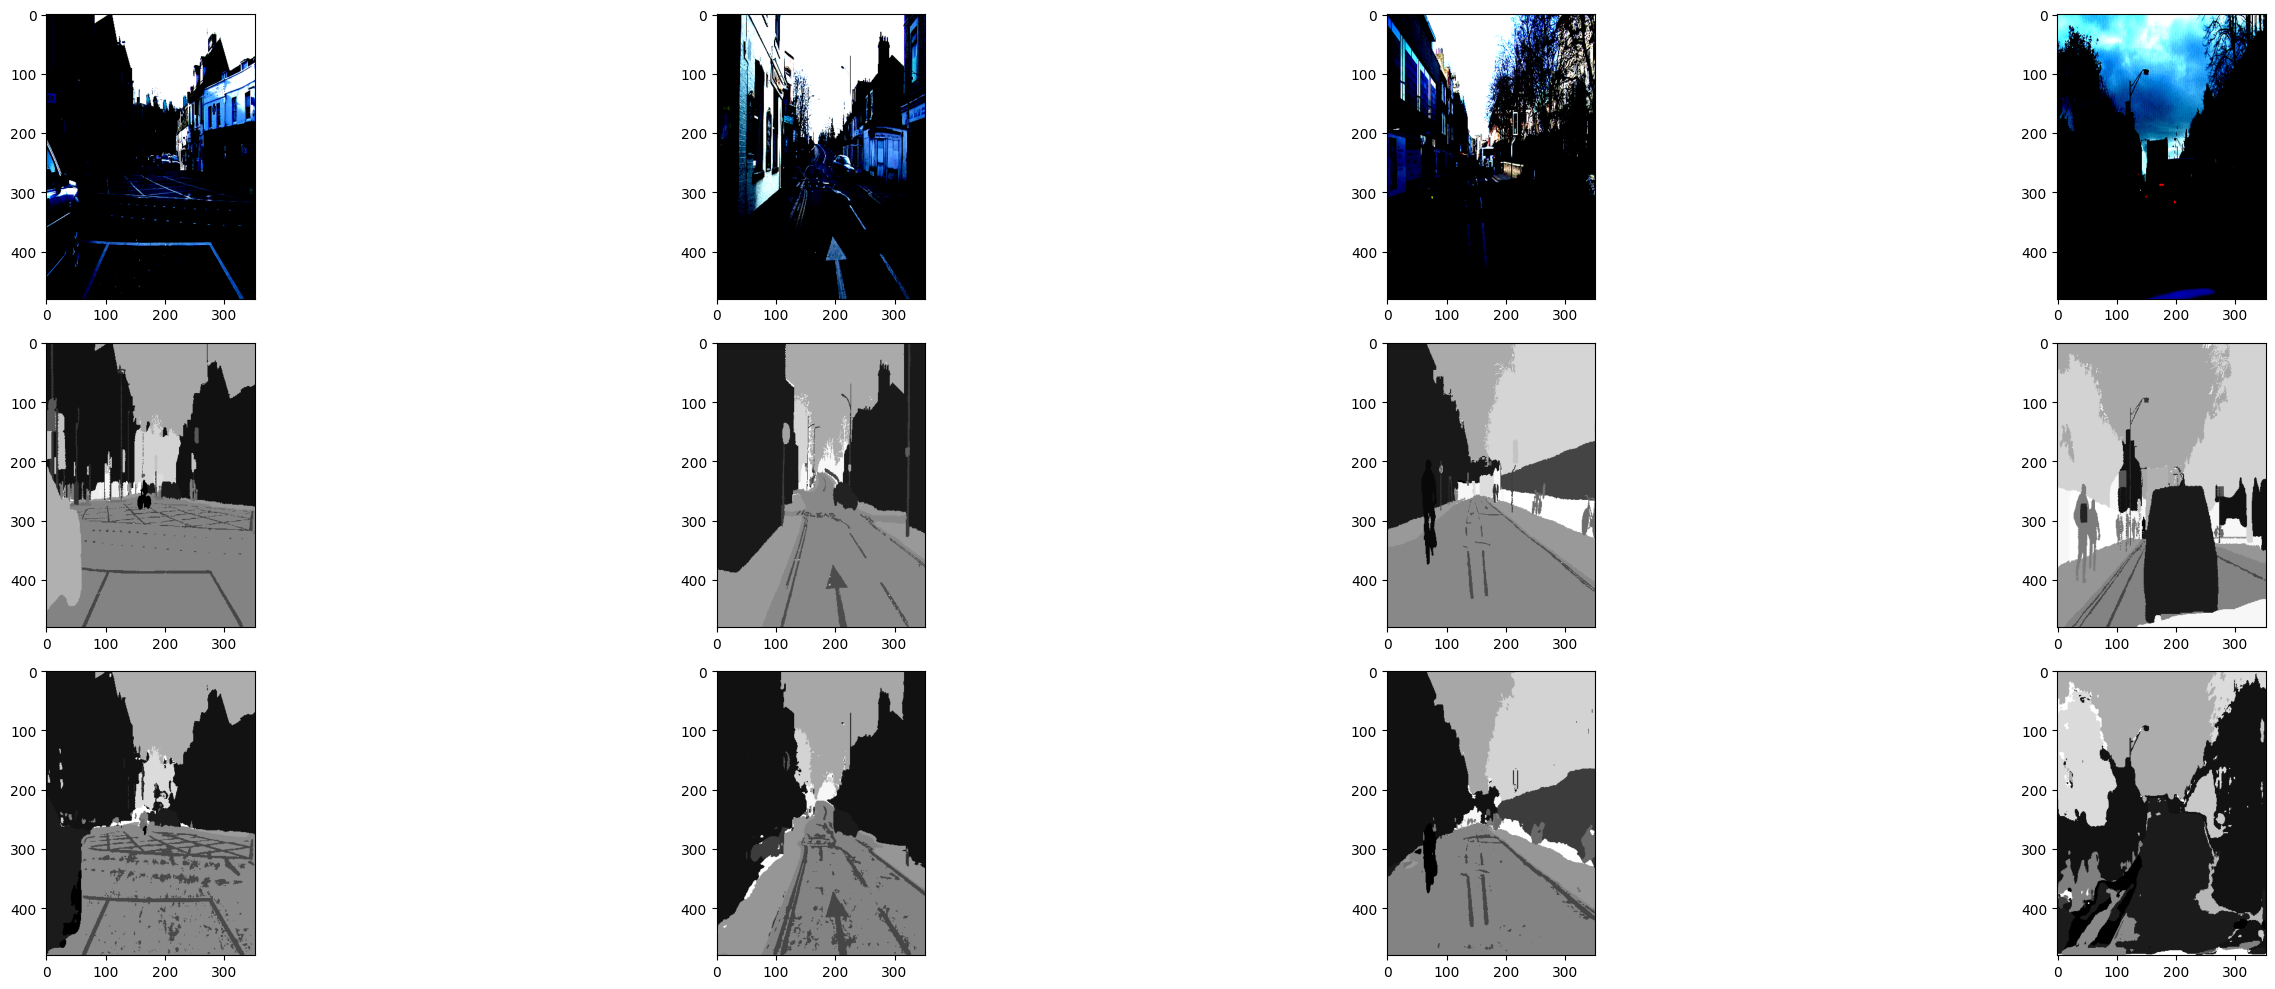

epoch 21/80 loss: 368647.951462766, acc: 0.004370217211544514, dic: 0.0036664216313511133, iou: 0.0030769137665629387
epoch 21/80 val_loss: 548516.6105769231, val_acc: 0.003959298133850098, val_dic: 0.0032353403512388468, val_iou: 0.0026519836392253637


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 22/80 loss: 362348.8070146277, acc: 0.0044167242012917995, dic: 0.0037349099293351173, iou: 0.0031347586773335934
epoch 22/80 val_loss: 386479.0216346154, val_acc: 0.004273385275155306, val_dic: 0.0036302374210208654, val_iou: 0.0030464099254459143


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 23/80 loss: 343178.53100066487, acc: 0.0045237489975988865, dic: 0.0037986491806805134, iou: 0.0032010229770094156
epoch 23/80 val_loss: 445579.8173076923, val_acc: 0.003989031072705984, val_dic: 0.003446516813710332, val_iou: 0.0028581093065440655


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 24/80 loss: 329069.3977726064, acc: 0.00464845122769475, dic: 0.0038651914801448584, iou: 0.0032499157823622227
epoch 24/80 val_loss: 395052.05528846156, val_acc: 0.004318112041801214, val_dic: 0.003632165025919676, val_iou: 0.003025459125638008


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 25/80 loss: 324564.4468916223, acc: 0.0047047436237335205, dic: 0.00392201729118824, iou: 0.0032895675394684076
epoch 25/80 val_loss: 401049.35817307694, val_acc: 0.0045560747385025024, val_dic: 0.0037335078231990337, val_iou: 0.0031447086948901415


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 26/80 loss: 305994.8582114362, acc: 0.004843595437705517, dic: 0.004002450034022331, iou: 0.0033730086870491505
epoch 26/80 val_loss: 431875.7283653846, val_acc: 0.004195119254291058, val_dic: 0.003585629863664508, val_iou: 0.0029719467274844646


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 27/80 loss: 296553.670212766, acc: 0.004900577012449503, dic: 0.004042450338602066, iou: 0.00340153556317091
epoch 27/80 val_loss: 370588.0492788461, val_acc: 0.004619121551513672, val_dic: 0.0038196765817701817, val_iou: 0.003185063134878874


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 28/80 loss: 296051.8738364362, acc: 0.004928101319819689, dic: 0.004055897239595652, iou: 0.003412369405850768
epoch 28/80 val_loss: 385013.0492788461, val_acc: 0.004608317743986845, val_dic: 0.0038641744758933783, val_iou: 0.00325338845141232


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 29/80 loss: 280208.46147772606, acc: 0.00513883912935853, dic: 0.004167838953435421, iou: 0.0035191490314900875
epoch 29/80 val_loss: 352059.96153846156, val_acc: 0.004893267527222633, val_dic: 0.003968223929405212, val_iou: 0.003307730657979846


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 30/80 loss: 272953.3816489362, acc: 0.0051976153627038, dic: 0.0041761319153010845, iou: 0.0035311689134687185
epoch 30/80 val_loss: 408006.1814903846, val_acc: 0.004431417211890221, val_dic: 0.003626813879236579, val_iou: 0.003013237612321973


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


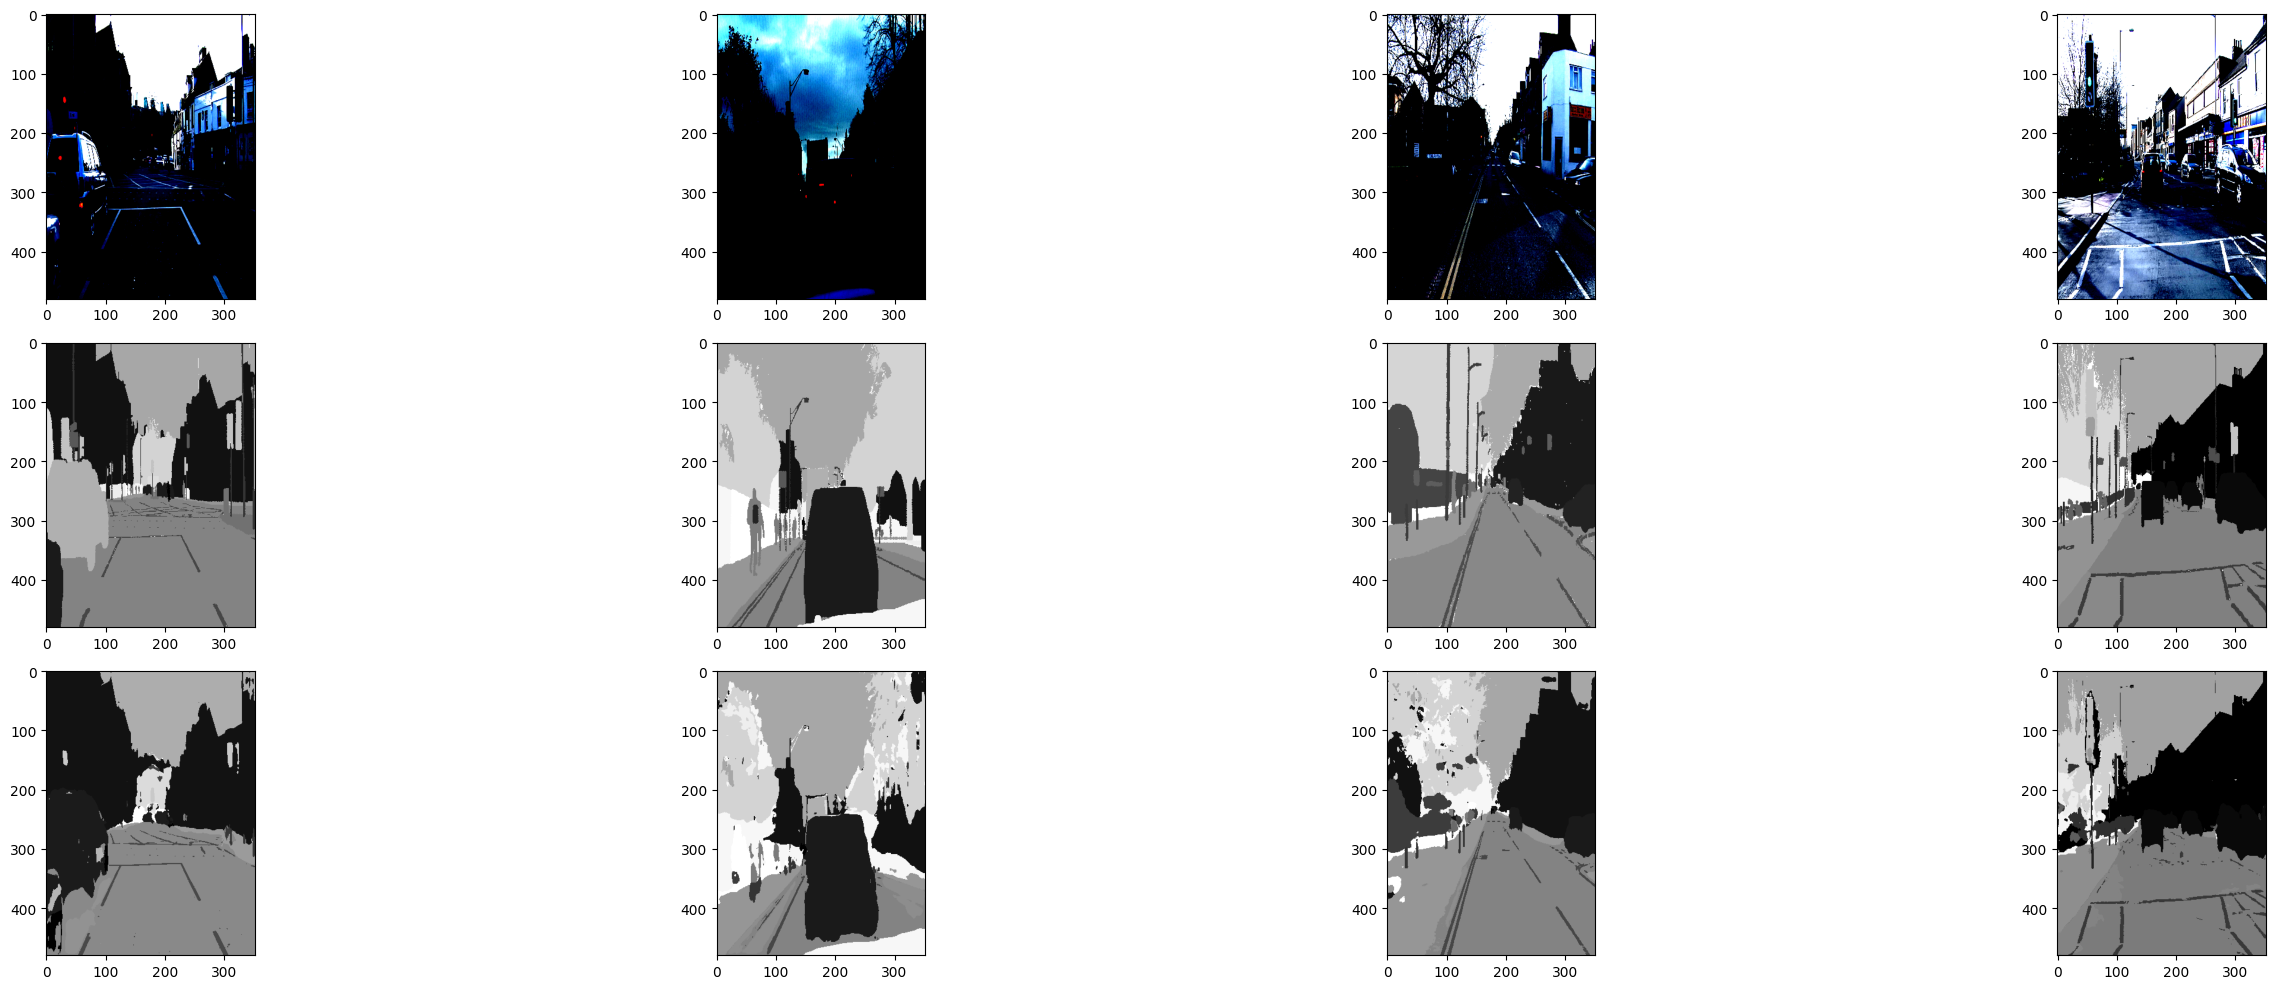

epoch 31/80 loss: 262592.7992436835, acc: 0.005335855297744274, dic: 0.0042776199989020824, iou: 0.0036199395544826984
epoch 31/80 val_loss: 384590.2403846154, val_acc: 0.0045631700195372105, val_dic: 0.003706122050061822, val_iou: 0.003103181254118681


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 32/80 loss: 243936.87799202127, acc: 0.005438378546386957, dic: 0.004337058402597904, iou: 0.0036787716671824455
epoch 32/80 val_loss: 396468.1201923077, val_acc: 0.004879598971456289, val_dic: 0.003846846055239439, val_iou: 0.003225223394110799


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 33/80 loss: 243421.55539394947, acc: 0.00554681196808815, dic: 0.0043690940365195274, iou: 0.0037038507871329784
epoch 33/80 val_loss: 335499.0408653846, val_acc: 0.00507180392742157, val_dic: 0.004076364915817976, val_iou: 0.0034132248256355524


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 34/80 loss: 238248.1790433843, acc: 0.005516733508557081, dic: 0.0044191619381308556, iou: 0.003758238861337304
epoch 34/80 val_loss: 336798.3858173077, val_acc: 0.004833871964365244, val_dic: 0.004012315068393946, val_iou: 0.0033809286542236805


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 35/80 loss: 224419.23956948137, acc: 0.005619141273200512, dic: 0.004476415924727917, iou: 0.003806190099567175
epoch 35/80 val_loss: 354031.88341346156, val_acc: 0.004936655052006245, val_dic: 0.004058293532580137, val_iou: 0.003398036817088723


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 36/80 loss: 235640.82280585106, acc: 0.005611984059214592, dic: 0.004421547055244446, iou: 0.0037515887524932623
epoch 36/80 val_loss: 319948.38341346156, val_acc: 0.005178936757147312, val_dic: 0.004114587791264057, val_iou: 0.0034518707543611526


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 37/80 loss: 217717.03316156915, acc: 0.005831551272422075, dic: 0.0045943669974803925, iou: 0.003910779021680355
epoch 37/80 val_loss: 302767.7127403846, val_acc: 0.0056409998796880245, val_dic: 0.0043385750614106655, val_iou: 0.0036385238636285067


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 38/80 loss: 205430.43321974733, acc: 0.005957986228168011, dic: 0.004668849986046553, iou: 0.003985625691711903
epoch 38/80 val_loss: 303773.9423076923, val_acc: 0.005232030060142279, val_dic: 0.004233486019074917, val_iou: 0.0035638355184346437


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 39/80 loss: 200585.35509474733, acc: 0.005942604970186949, dic: 0.0046608177945017815, iou: 0.003977106884121895
epoch 39/80 val_loss: 354466.90264423075, val_acc: 0.00495712598785758, val_dic: 0.004051152151077986, val_iou: 0.003386366181075573


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 40/80 loss: 193752.76828457447, acc: 0.0060742381028831005, dic: 0.004716399125754833, iou: 0.004029523581266403
epoch 40/80 val_loss: 298235.29026442306, val_acc: 0.005391937214881182, val_dic: 0.004321941174566746, val_iou: 0.0036378970835357904


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


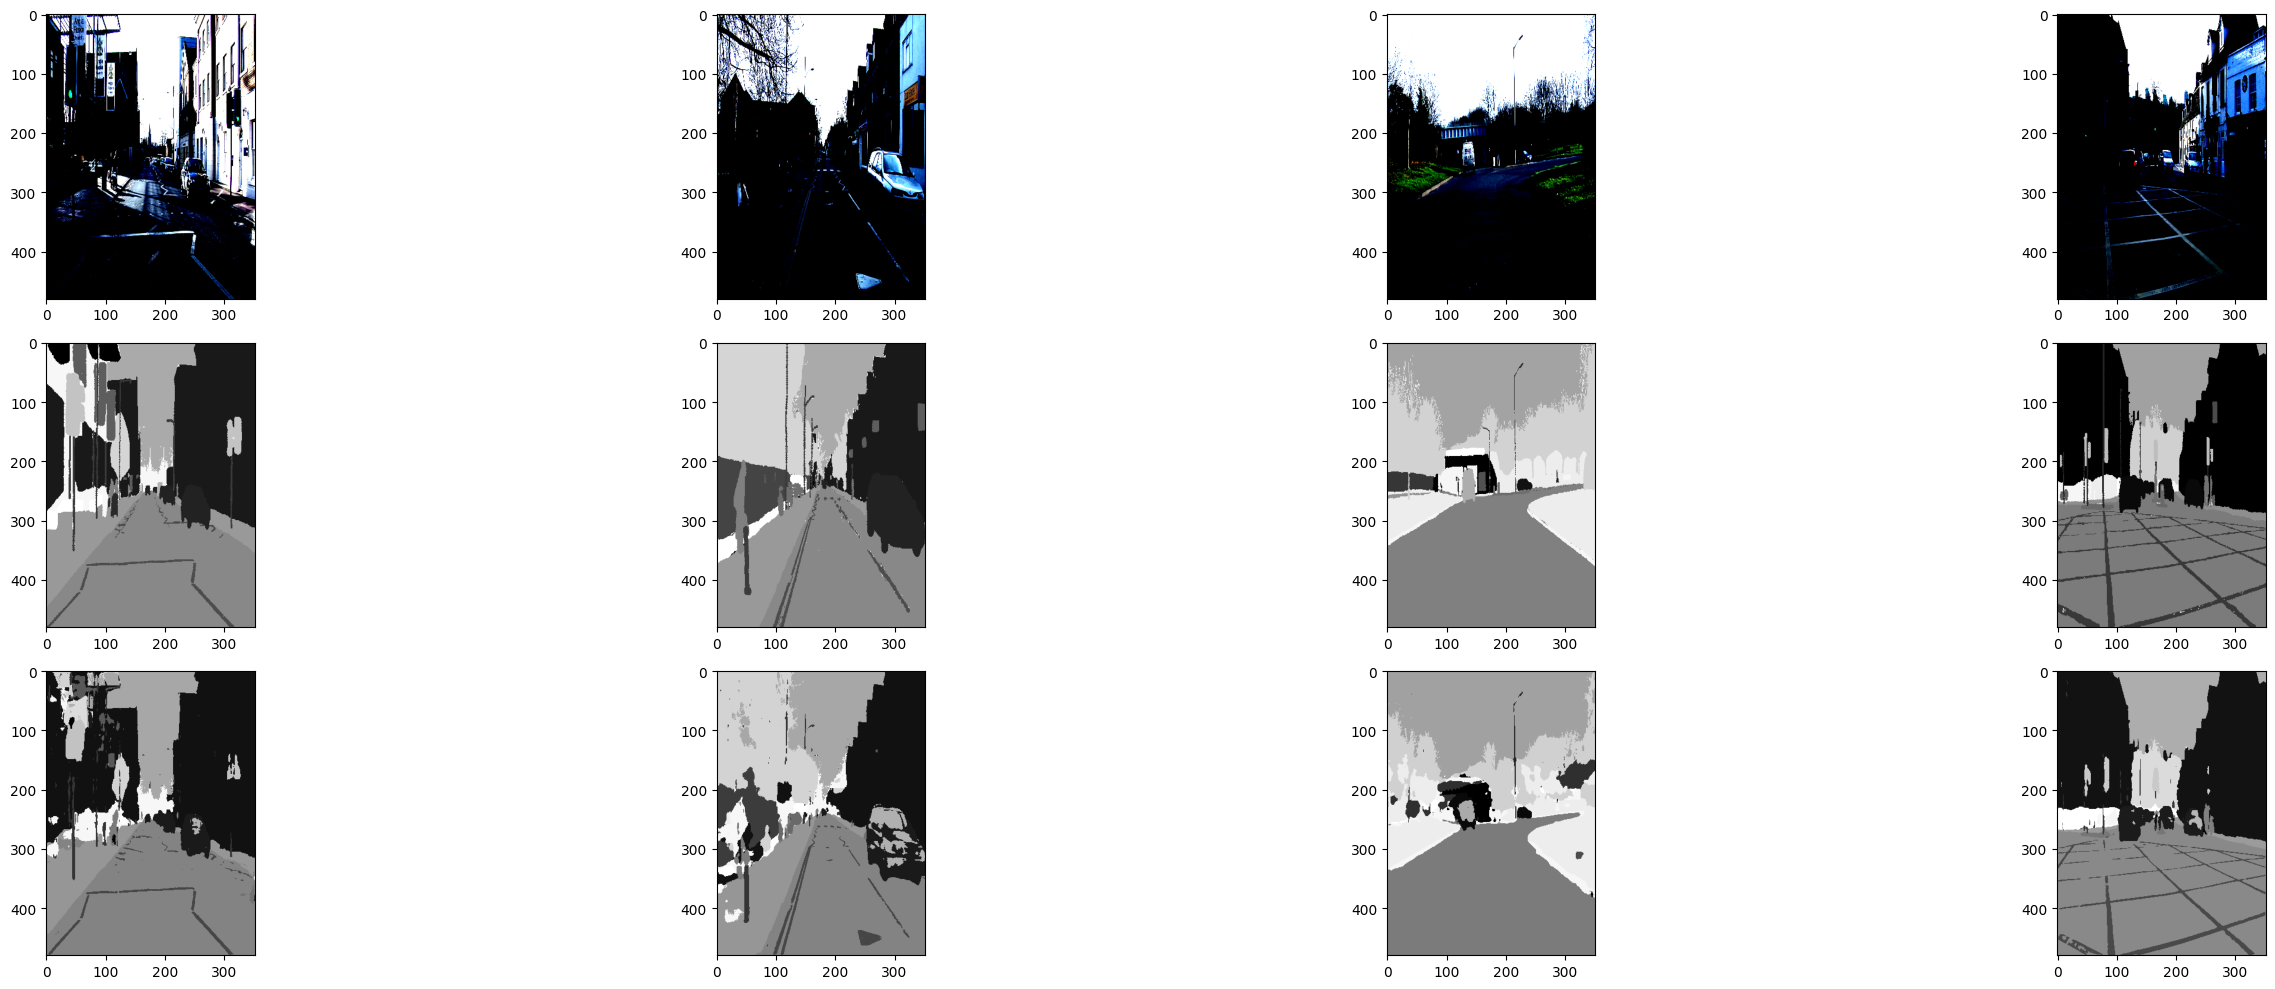

epoch 41/80 loss: 183167.22057845743, acc: 0.006186575163155794, dic: 0.004798891022801399, iou: 0.004108382388949394
epoch 41/80 val_loss: 324821.625, val_acc: 0.005374796222895384, val_dic: 0.004241099581122398, val_iou: 0.0035448207054287195


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 42/80 loss: 183408.6487699468, acc: 0.00625039916485548, dic: 0.004836571868509054, iou: 0.0041316901333630085
epoch 42/80 val_loss: 296775.5132211539, val_acc: 0.0058059971779584885, val_dic: 0.004440439864993095, val_iou: 0.0037389216013252735


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 43/80 loss: 170457.5487450133, acc: 0.006494041997939348, dic: 0.0049589853733778, iou: 0.004250832833349705
epoch 43/80 val_loss: 275250.31610576925, val_acc: 0.0056593515910208225, val_dic: 0.0043915207497775555, val_iou: 0.0036889195907860994


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 44/80 loss: 163948.2770944149, acc: 0.00653799856081605, dic: 0.004986950196325779, iou: 0.004279885906726122
epoch 44/80 val_loss: 306952.1935096154, val_acc: 0.00561238918453455, val_dic: 0.004379027523100376, val_iou: 0.0036939429119229317


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 45/80 loss: 156072.00349069148, acc: 0.006676231510937214, dic: 0.00503219198435545, iou: 0.004329234827309847
epoch 45/80 val_loss: 310323.63221153844, val_acc: 0.006229759659618139, val_dic: 0.004556199535727501, val_iou: 0.003812067909166217


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 46/80 loss: 151683.8318650266, acc: 0.00683359382674098, dic: 0.005126727744936943, iou: 0.004413887392729521
epoch 46/80 val_loss: 276445.6310096154, val_acc: 0.006257569883018732, val_dic: 0.00475394306704402, val_iou: 0.004022992681711912


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 47/80 loss: 142732.56000664894, acc: 0.006991957314312458, dic: 0.00520330062136054, iou: 0.004488919861614704
epoch 47/80 val_loss: 303496.9326923077, val_acc: 0.0056808325462043285, val_dic: 0.004492083098739386, val_iou: 0.0037984936498105526


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 48/80 loss: 137578.5973238032, acc: 0.007038665935397148, dic: 0.005280455574393272, iou: 0.004566612653434277
epoch 48/80 val_loss: 260959.63040865384, val_acc: 0.006356355268508196, val_dic: 0.00487808883190155, val_iou: 0.004137699026614428


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 49/80 loss: 131402.9564494681, acc: 0.00726142106577754, dic: 0.005378587171435356, iou: 0.004657594487071037
epoch 49/80 val_loss: 265609.36658653844, val_acc: 0.00644295709207654, val_dic: 0.004890024662017822, val_iou: 0.004150858148932457


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 50/80 loss: 130714.11685505319, acc: 0.007326807361096144, dic: 0.005359096452593803, iou: 0.004648466128855944
epoch 50/80 val_loss: 287721.13341346156, val_acc: 0.006046641152352095, val_dic: 0.004640406463295221, val_iou: 0.003906112862750888


100%|██████████| 47/47 [00:31<00:00,  1.52it/s]


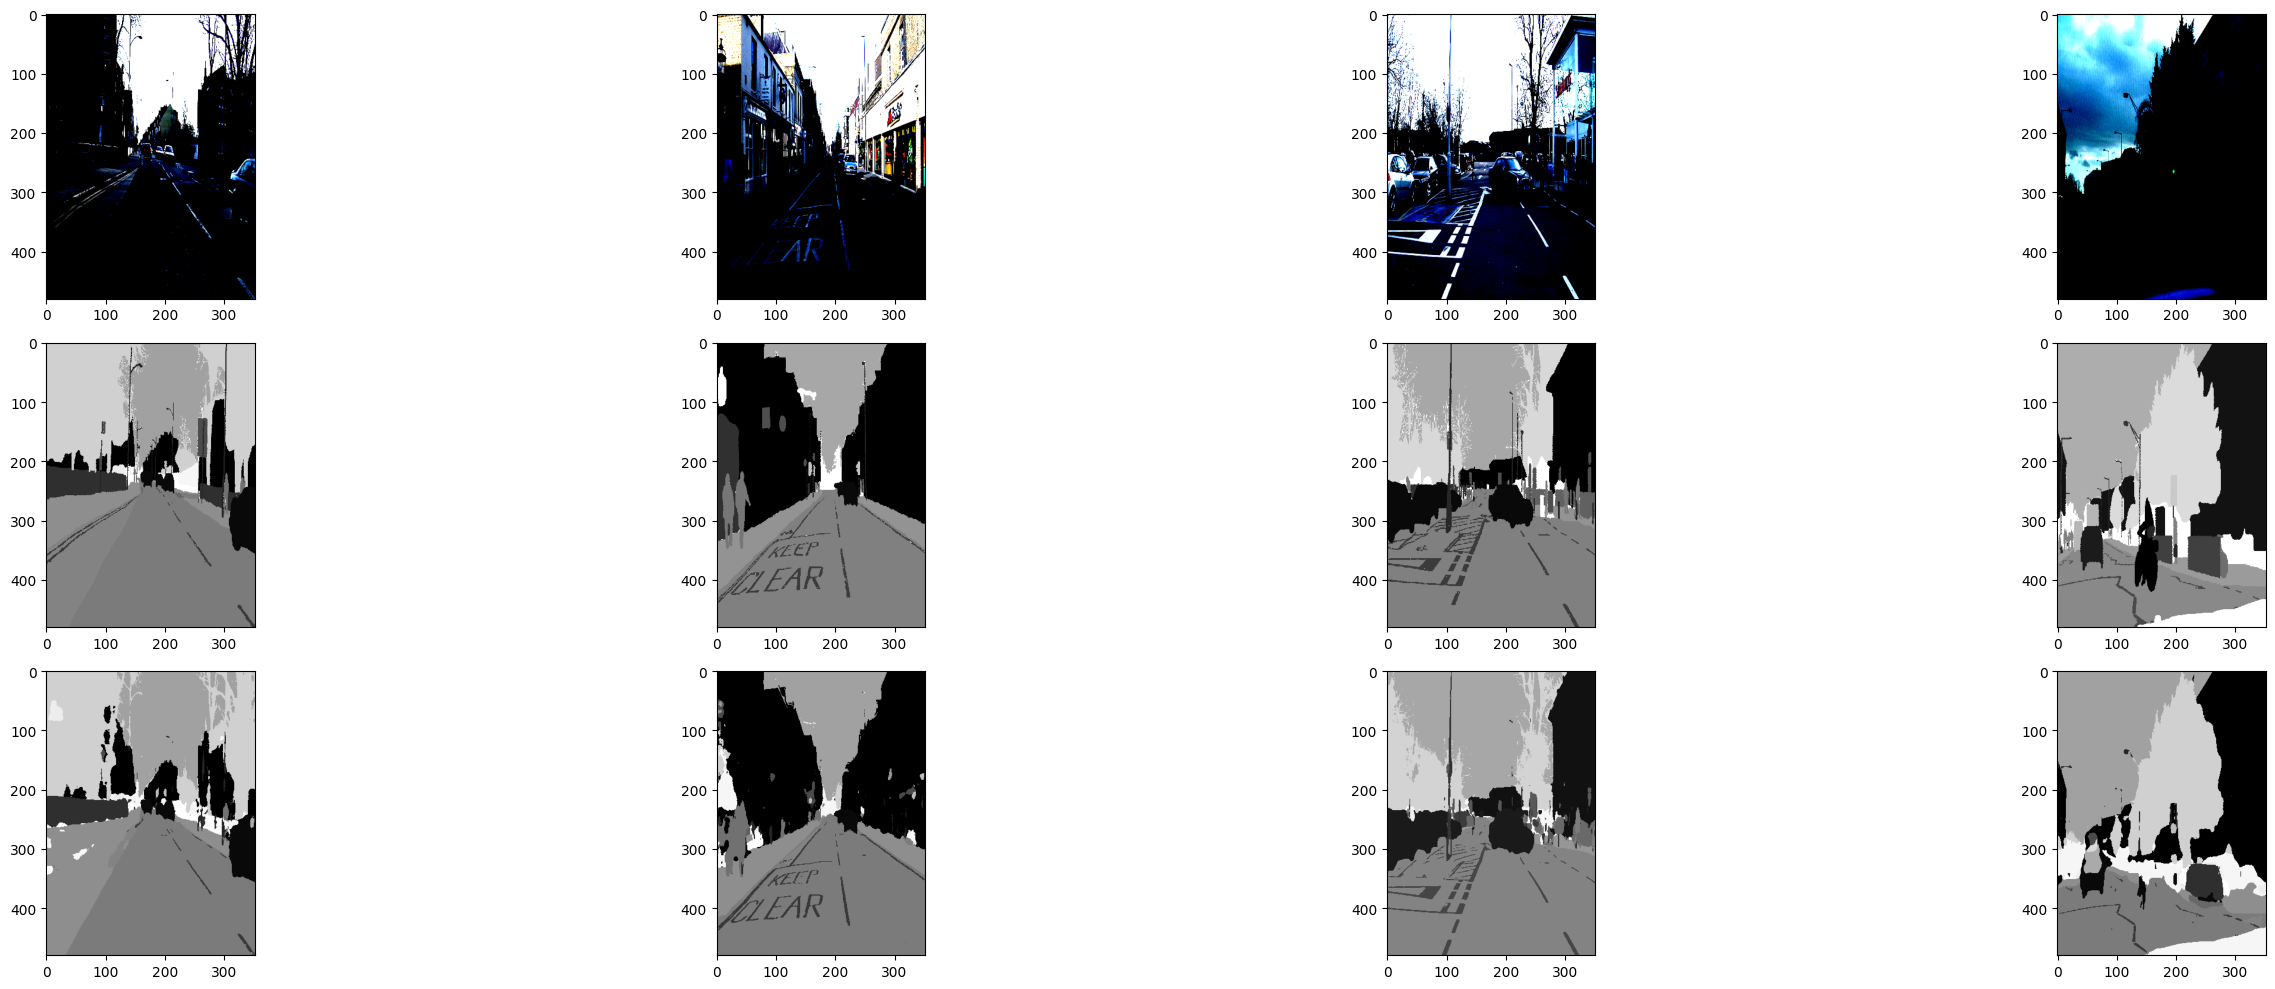

epoch 51/80 loss: 121027.61751994681, acc: 0.007535092066973448, dic: 0.005467094015330076, iou: 0.0047507802955806255
epoch 51/80 val_loss: 279596.63942307694, val_acc: 0.0064916242845356464, val_dic: 0.00487287575379014, val_iou: 0.004122009035199881


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 52/80 loss: 115089.15433843085, acc: 0.0077377506531775, dic: 0.005557965021580458, iou: 0.004841247573494911
epoch 52/80 val_loss: 261824.23677884616, val_acc: 0.006581380032002926, val_dic: 0.004893305245786905, val_iou: 0.004140152595937252


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 53/80 loss: 109815.56748670213, acc: 0.007883483543992043, dic: 0.00564208859577775, iou: 0.00492463493719697
epoch 53/80 val_loss: 276879.4483173077, val_acc: 0.006506126839667559, val_dic: 0.004869407974183559, val_iou: 0.004134768154472113


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 54/80 loss: 107282.48107130984, acc: 0.007818753831088543, dic: 0.005653509870171547, iou: 0.004942954983562231
epoch 54/80 val_loss: 272078.1923076923, val_acc: 0.006494222674518824, val_dic: 0.004930952098220587, val_iou: 0.004179717507213354


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 55/80 loss: 100891.02524517952, acc: 0.00803704746067524, dic: 0.005738907027989626, iou: 0.005033681634813547
epoch 55/80 val_loss: 276385.84014423075, val_acc: 0.006635615136474371, val_dic: 0.004943589214235544, val_iou: 0.004183907527476549


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 56/80 loss: 97150.98686835106, acc: 0.008312479592859745, dic: 0.005836872383952141, iou: 0.00512301828712225
epoch 56/80 val_loss: 262119.03485576922, val_acc: 0.0065941889770329, val_dic: 0.004996909759938717, val_iou: 0.004245060030370951


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 57/80 loss: 93169.91956865026, acc: 0.008284861221909523, dic: 0.005895906127989292, iou: 0.005182893015444279
epoch 57/80 val_loss: 266412.47716346156, val_acc: 0.006813591346144676, val_dic: 0.005109462421387434, val_iou: 0.0043547251261770725


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 58/80 loss: 90807.89731549202, acc: 0.008345789276063442, dic: 0.005930856801569462, iou: 0.005218193866312504
epoch 58/80 val_loss: 252892.9735576923, val_acc: 0.007093855645507574, val_dic: 0.0051203020848333836, val_iou: 0.004346026107668877


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 59/80 loss: 86637.26633144947, acc: 0.008480366319417953, dic: 0.0059606051072478294, iou: 0.005258029326796532
epoch 59/80 val_loss: 283858.7872596154, val_acc: 0.0066769057884812355, val_dic: 0.004960951860994101, val_iou: 0.004213082604110241


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 60/80 loss: 82681.92893949468, acc: 0.008767045103013515, dic: 0.006056563463062048, iou: 0.005355999805033207
epoch 60/80 val_loss: 273879.30588942306, val_acc: 0.0066444287076592445, val_dic: 0.0049638948403298855, val_iou: 0.004227487836033106


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


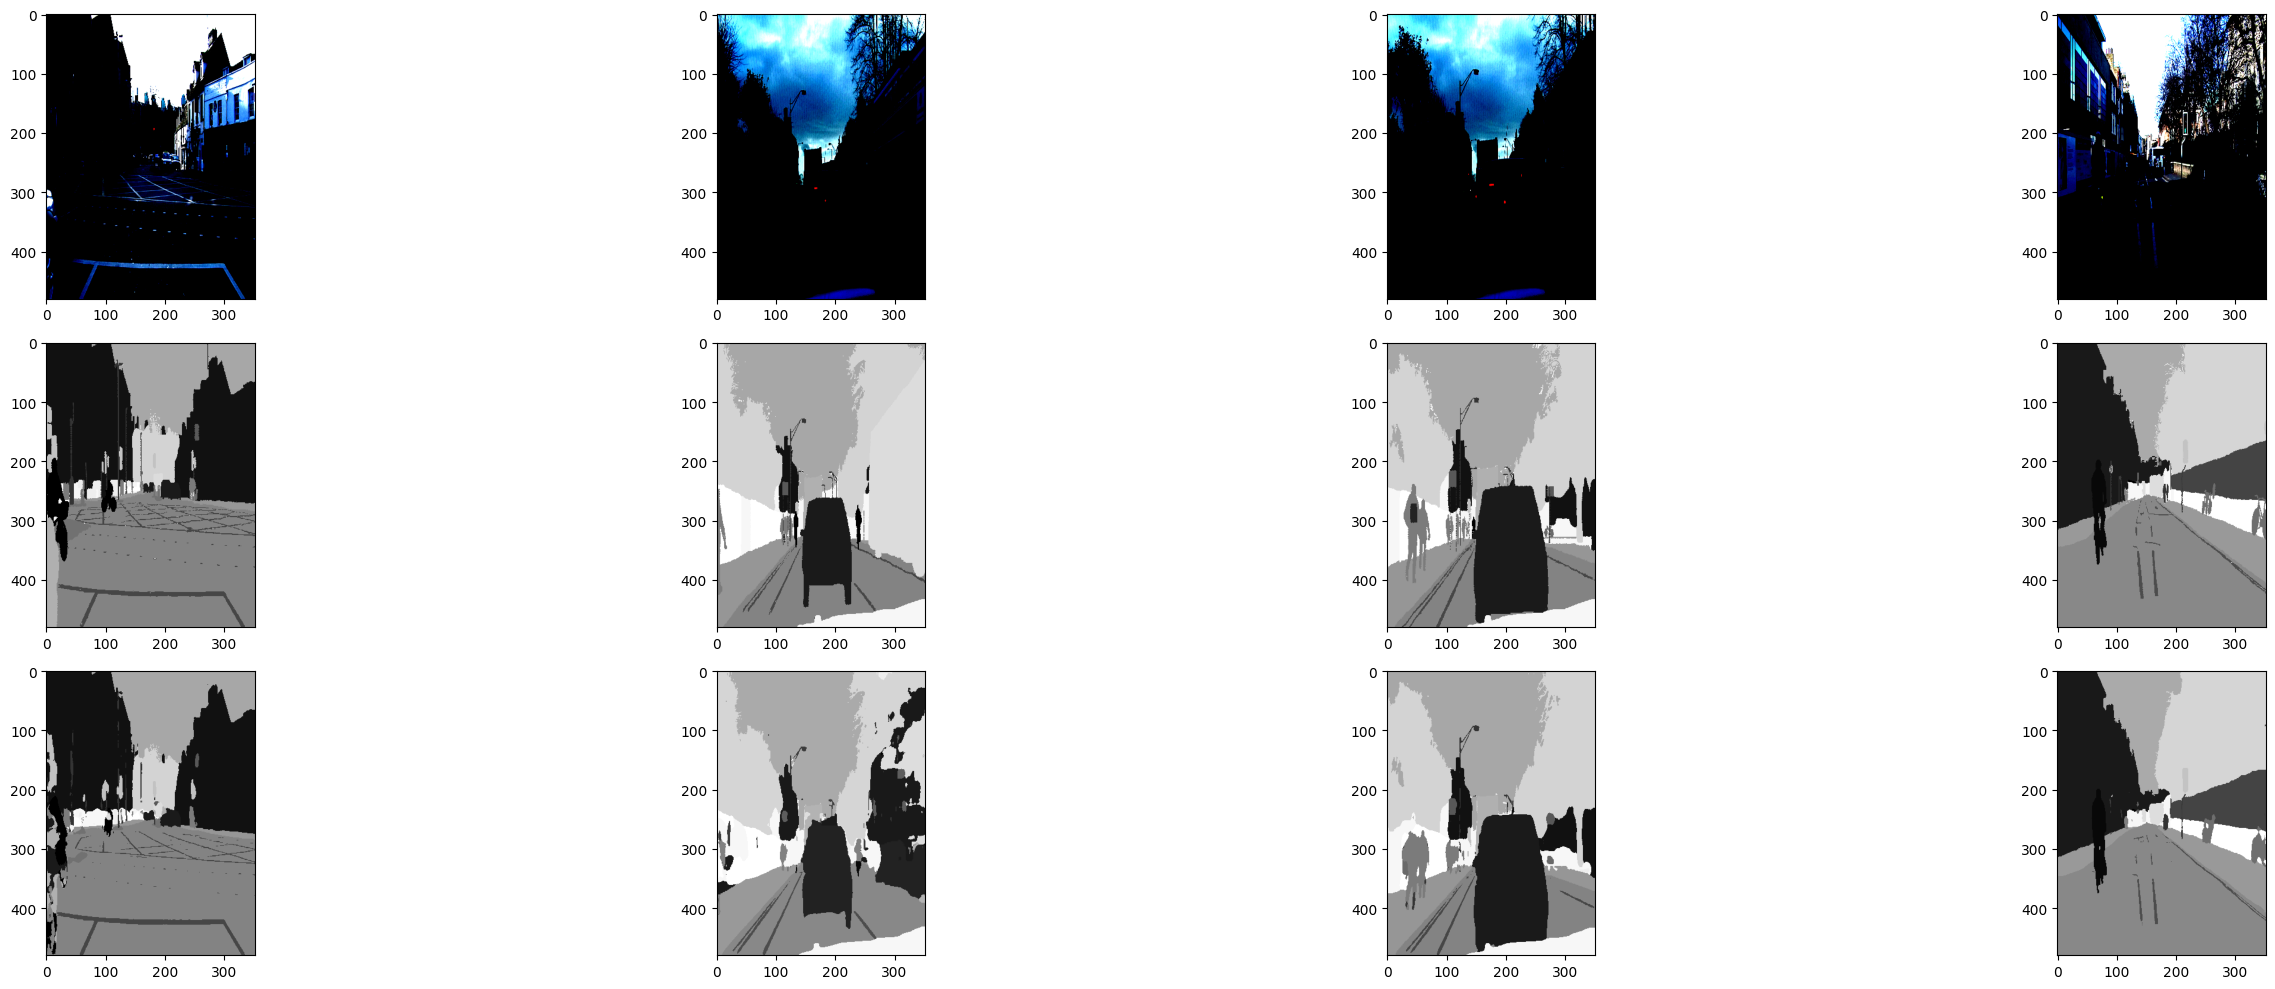

epoch 61/80 loss: 80933.4260305851, acc: 0.00873180665075779, dic: 0.006074309349060059, iou: 0.005370228551328182
epoch 61/80 val_loss: 264569.2680288461, val_acc: 0.007238434627652168, val_dic: 0.005221623927354813, val_iou: 0.0044533382169902325


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 62/80 loss: 76975.47398603724, acc: 0.008722230792045593, dic: 0.006164441350847483, iou: 0.005462920293211937
epoch 62/80 val_loss: 273130.51442307694, val_acc: 0.006980219390243292, val_dic: 0.005088926758617163, val_iou: 0.004337900783866644


100%|██████████| 47/47 [00:30<00:00,  1.52it/s]


epoch 63/80 loss: 75372.29741522606, acc: 0.008946457877755165, dic: 0.0062591456808149815, iou: 0.005556703545153141
epoch 63/80 val_loss: 269949.97235576925, val_acc: 0.006990738678723574, val_dic: 0.00512463366612792, val_iou: 0.004366039298474789


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 64/80 loss: 73327.3732130984, acc: 0.009010789915919304, dic: 0.006255733780562878, iou: 0.005548560526221991
epoch 64/80 val_loss: 277028.89182692306, val_acc: 0.007080859038978815, val_dic: 0.005207237787544727, val_iou: 0.004450340289622545


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 65/80 loss: 72579.21251662234, acc: 0.009076687507331371, dic: 0.006249160040169954, iou: 0.005554607603698969
epoch 65/80 val_loss: 266630.69110576925, val_acc: 0.007300489582121372, val_dic: 0.00522161740809679, val_iou: 0.004457568284124136


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 66/80 loss: 71553.89627659574, acc: 0.008946629241108894, dic: 0.0062691387720406055, iou: 0.005575105547904968
epoch 66/80 val_loss: 270793.6201923077, val_acc: 0.00712251802906394, val_dic: 0.005175448954105377, val_iou: 0.0044181011617183685


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 67/80 loss: 71110.73287898937, acc: 0.009204625152051449, dic: 0.0062910872511565685, iou: 0.005603252910077572
epoch 67/80 val_loss: 271185.90564903844, val_acc: 0.007295462302863598, val_dic: 0.005241272505372763, val_iou: 0.004474072717130184


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 68/80 loss: 65859.73715924202, acc: 0.009302073158323765, dic: 0.006378806661814451, iou: 0.005693692248314619
epoch 68/80 val_loss: 281090.12860576925, val_acc: 0.006935920566320419, val_dic: 0.005131492856889963, val_iou: 0.004379799589514732


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 69/80 loss: 64200.70826753657, acc: 0.00944326352328062, dic: 0.006459575612097979, iou: 0.0057680681347846985
epoch 69/80 val_loss: 282107.3305288461, val_acc: 0.007102108094841242, val_dic: 0.005179561208933592, val_iou: 0.0044234818778932095


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 70/80 loss: 64209.32646276596, acc: 0.009433886967599392, dic: 0.0064453925006091595, iou: 0.005751885008066893
epoch 70/80 val_loss: 277905.3389423077, val_acc: 0.007143275812268257, val_dic: 0.005174154881387949, val_iou: 0.004416543524712324


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


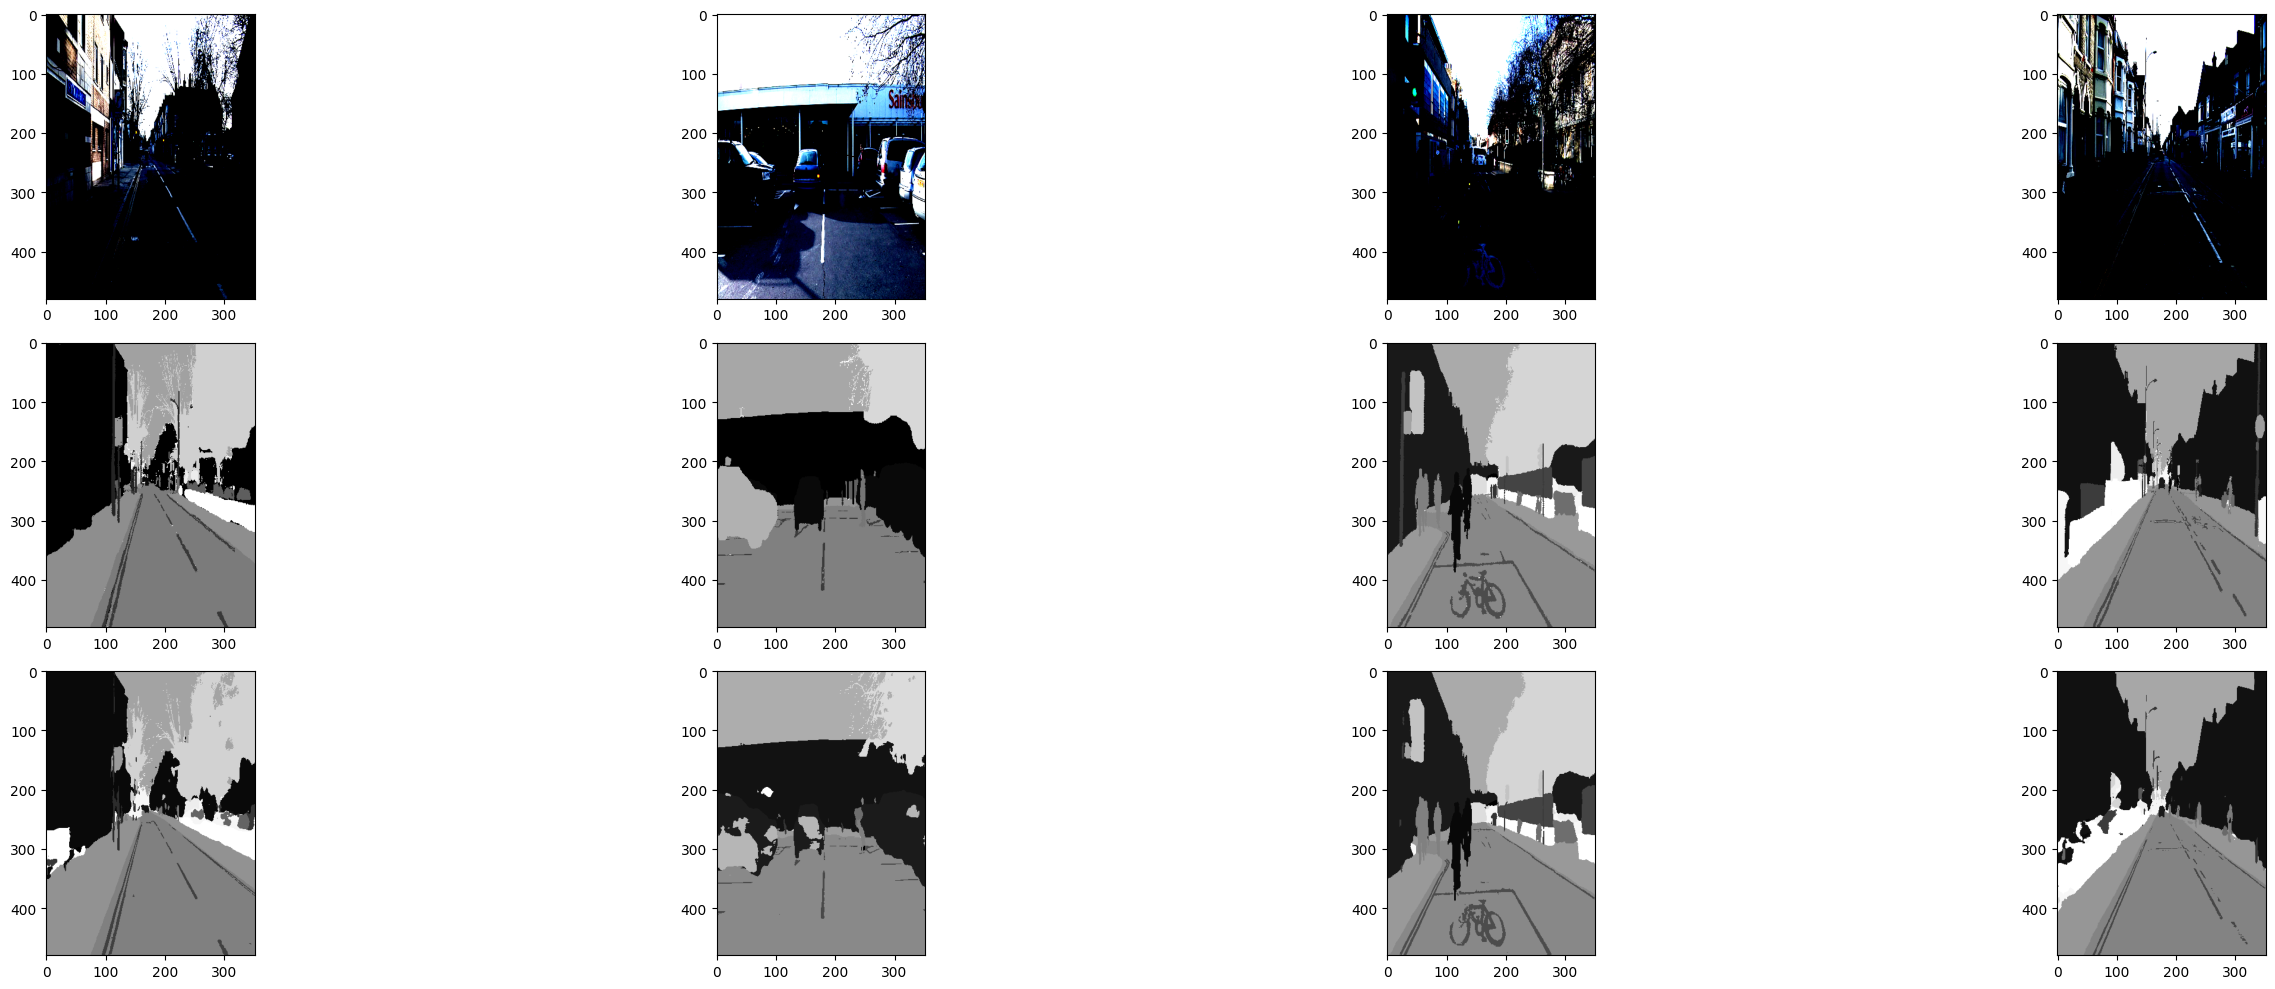

epoch 71/80 loss: 62893.14552859042, acc: 0.009438847191631794, dic: 0.006461515091359615, iou: 0.005774026270955801
epoch 71/80 val_loss: 284832.97235576925, val_acc: 0.007321088574826717, val_dic: 0.005194058176130056, val_iou: 0.004434605594724417


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 72/80 loss: 65831.59607712766, acc: 0.009554203599691391, dic: 0.006426880601793528, iou: 0.00574488053098321
epoch 72/80 val_loss: 281606.84435096156, val_acc: 0.0073324451223015785, val_dic: 0.005260980688035488, val_iou: 0.004497140180319548


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 73/80 loss: 60912.693006150264, acc: 0.009637043811380863, dic: 0.006508669815957546, iou: 0.0058275447227060795
epoch 73/80 val_loss: 282054.45192307694, val_acc: 0.00721313338726759, val_dic: 0.005208689719438553, val_iou: 0.004442813340574503


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 74/80 loss: 60925.03307845745, acc: 0.00961262546479702, dic: 0.006535476539283991, iou: 0.005844095256179571
epoch 74/80 val_loss: 280996.6274038461, val_acc: 0.007186852861195803, val_dic: 0.005224070977419615, val_iou: 0.004463754128664732


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 75/80 loss: 60146.55329537899, acc: 0.00966227613389492, dic: 0.0065881479531526566, iou: 0.005902612116187811
epoch 75/80 val_loss: 284624.3617788461, val_acc: 0.00718665961176157, val_dic: 0.005227614194154739, val_iou: 0.004461884964257479


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 76/80 loss: 59618.750332446805, acc: 0.009659679606556892, dic: 0.006524040363729, iou: 0.005843315273523331
epoch 76/80 val_loss: 284146.0841346154, val_acc: 0.007188812363892794, val_dic: 0.005212701857089996, val_iou: 0.004455447196960449


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 77/80 loss: 59296.21463597075, acc: 0.009561042301356792, dic: 0.0065601058304309845, iou: 0.005875033792108297
epoch 77/80 val_loss: 285191.18629807694, val_acc: 0.007025897968560457, val_dic: 0.005205967929214239, val_iou: 0.004442737437784672


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 78/80 loss: 59076.914883228055, acc: 0.009763590060174465, dic: 0.006598601117730141, iou: 0.005916181951761246
epoch 78/80 val_loss: 284904.8530649039, val_acc: 0.007277787197381258, val_dic: 0.005270078312605619, val_iou: 0.004509067628532648


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


epoch 79/80 loss: 58912.390458776594, acc: 0.00958240032196045, dic: 0.006551125552505255, iou: 0.005870722699910402
epoch 79/80 val_loss: 283216.8653846154, val_acc: 0.0072249192744493484, val_dic: 0.0051896036602556705, val_iou: 0.0044274358078837395


 36%|███▌      | 17/47 [00:12<00:19,  1.54it/s]

In [ ]:
train_hist = []
val_hist = []
for epoch in range(epochs):
    model.train()
    running_dice = 0
    running_iou = 0
    running_acc = 0
    running_loss = 0
    
    for image, mask in tqdm(train_loader):
        image, mask = image.to(device), mask.to(device)

        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, mask)
        running_loss += loss.item()
        a = accuracy(pred, mask)
        d = dice(pred, mask)
        i = iou(pred, mask)
        
        running_acc += a
        running_dice += d
        running_iou += i
        
        train_hist.append((loss.item(), a, d, i))
                
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        lr_scheduler.step()
    running_acc /= len(train_loader)
    running_dice /= len(train_loader)
    running_iou /= len(train_loader)
    running_loss /= len(train_loader)
    
    model.eval()
    val_acc = 0
    val_dice = 0
    val_iou = 0
    val_loss = 0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)
            pred = model(image)

            loss = criterion(pred, mask)
            a = accuracy(pred, mask)
            d = dice(pred, mask)
            i = iou(pred, mask)
            
            val_loss += loss.item()
            val_acc += a
            val_dice += d
            val_iou += i

            val_hist.append((loss.item(), a, d, i))

        val_acc /= len(val_loader)
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)
        val_loss /= len(val_loader)

        if not epoch%10:
            num_rows = 3
            image = image[:4]
            mask = mask[:4]
            pred = pred[:4]
            num_cols = len(image)
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 10))
            
            for i in range(num_cols):
                axes[0, i].imshow(image[i].permute(1, 2, 0).cpu())
                axes[1, i].imshow(mask[i].cpu(), cmap="gray")
                # print(torch.unique(pred[i].argmax(0)), pred.size())
                axes[2, i].imshow(pred[i].argmax(0).cpu(), cmap="gray")
            
            plt.tight_layout()
            plt.show()

            # tracker(pred, mask, loss=loss.item())
    print(f"epoch {epoch+1}/{epochs} loss: {running_loss}, acc: {running_acc}, dic: {running_dice}, iou: {running_iou}")
    print(f"epoch {epoch+1}/{epochs} val_loss: {val_loss}, val_acc: {val_acc}, val_dic: {val_dice}, val_iou: {val_iou}")

In [49]:
torch.save(model.state_dict(), "camvid-seg-model.pth")

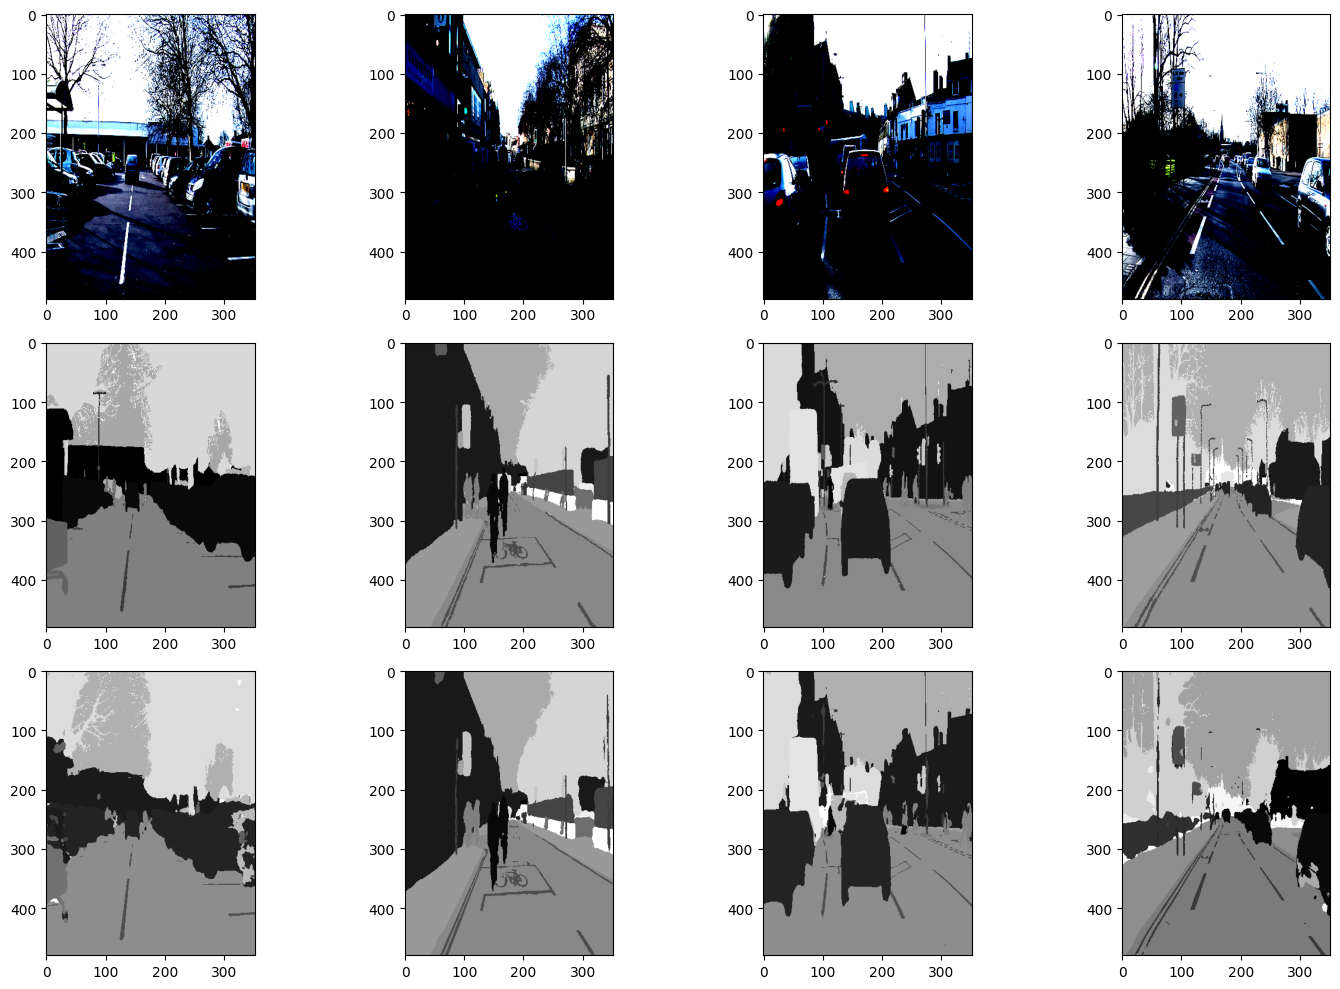

In [48]:
for image, mask in test_loader:
    image, mask = image.to(device), mask.to(device)
    break
num_rows = 3
image = image[:4]
mask = mask[:4]
pred = model(image)
pred = pred[:4]
num_cols = len(image)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i in range(num_cols):
    axes[0, i].imshow(image[i].permute(1, 2, 0).cpu())
    axes[1, i].imshow(mask[i].cpu(), cmap="gray")
    # print(torch.unique(pred[i].argmax(0)), pred.size())
    axes[2, i].imshow(pred[i].argmax(0).cpu(), cmap="gray")

plt.tight_layout()
plt.show()

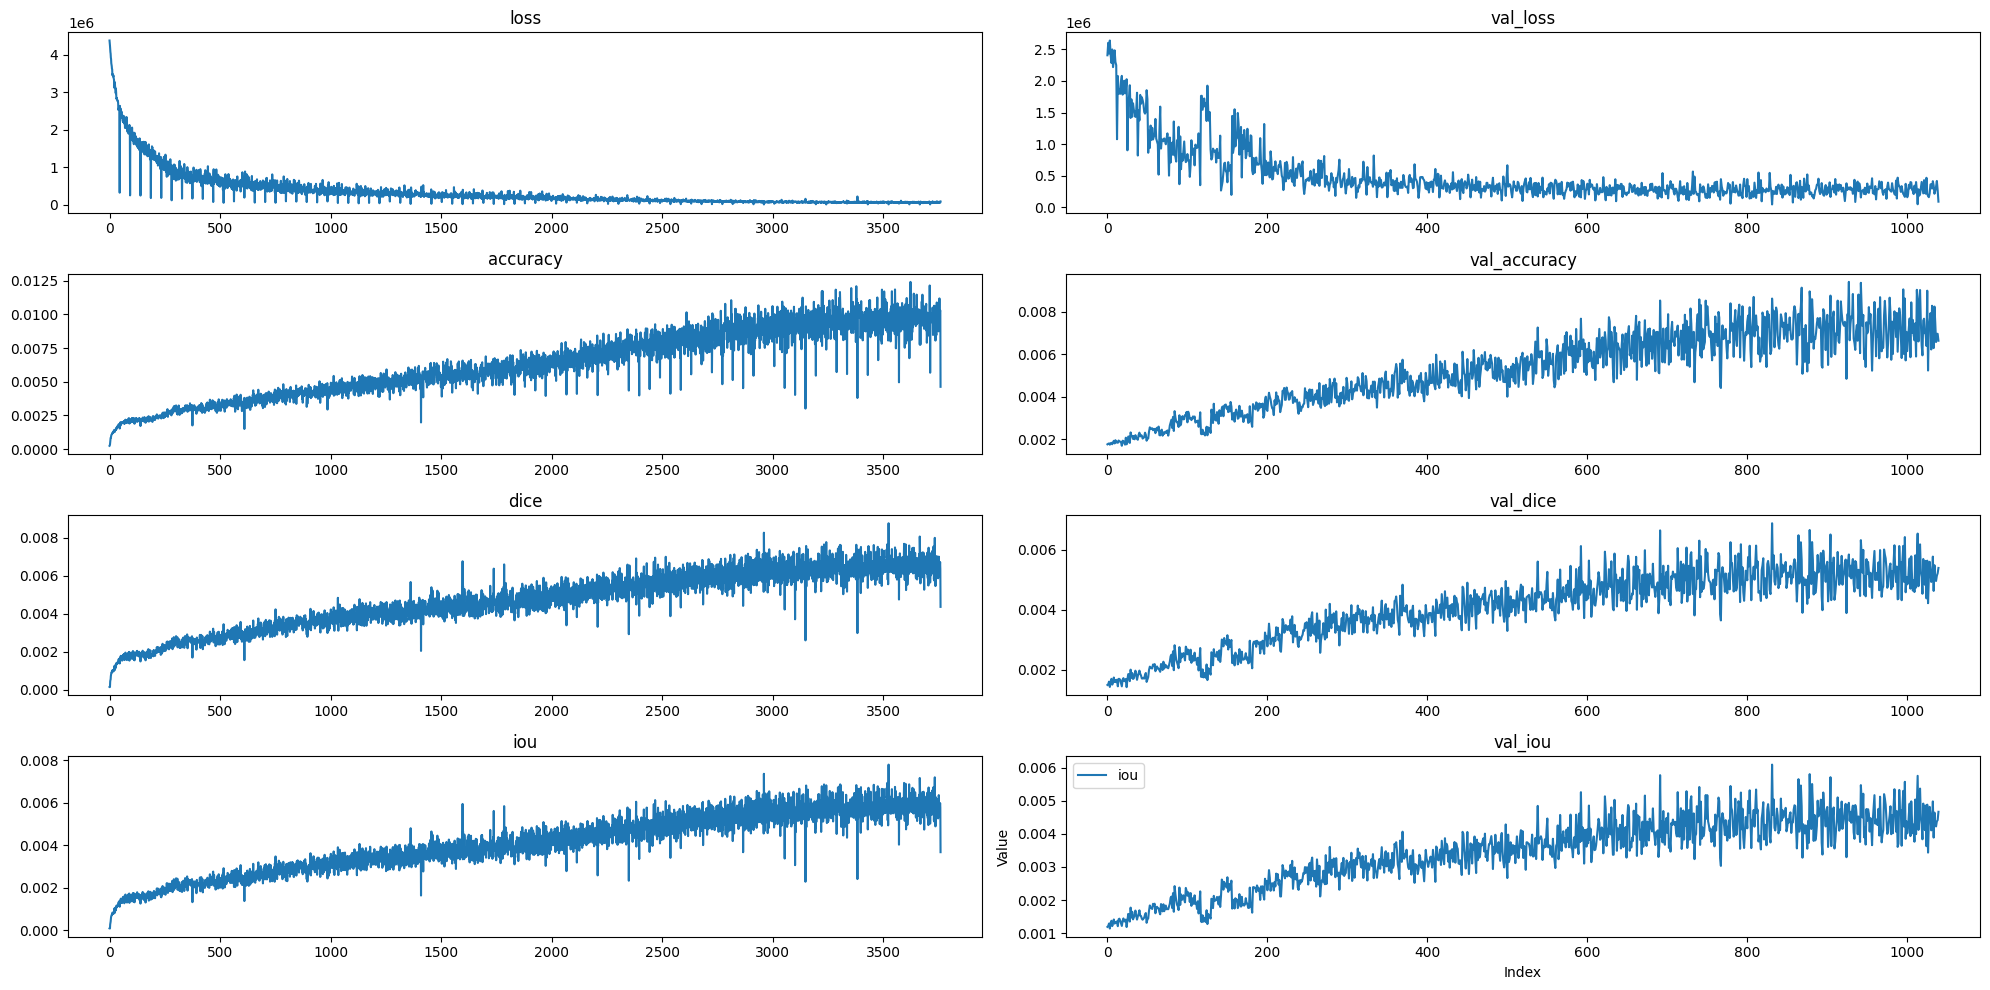

In [42]:
hists = [train_hist, val_hist]
metrics = ["loss", "accuracy", "dice", "iou"]

fig, axes = plt.subplots(len(metrics), 2, figsize=(20, 10))

for hi, hist in enumerate(hists):
    for i, m in enumerate(metrics):
        # print(m)
        if m in  ["accuracy", "dice", "iou"]:
            line = [row[i].cpu() for row in hist]
        else:
            line = [row[i] for row in hist]

        # print(line[:4])
        axes[i, hi].plot(line, label=m)
        axes[i, hi].set_title(f"{'val_' if hist == val_hist else ''}" + m)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [20]:
model_path = "/kaggle/input/camvid-unet/pytorch/default/1/camvid-seg-model.pth"

In [33]:
trained_model_weights = torch.load(model_path, weights_only=True, map_location=torch.device('cpu'))

In [34]:
model = UNet(3, num_classes).to(device)

In [42]:
model.load_state_dict(trained_model_weights)

<All keys matched successfully>